In [8]:
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import time
import networkx as nx
import pandas as pd
from math import radians, sin, cos, asin, sqrt
from scipy.spatial import Delaunay
from shapely.geometry import LineString

import warnings
warnings.filterwarnings("ignore")

import fiona

In [9]:
# A sample of buildings, assumed to be buildings to place in ONE distribution grid

# TODO Check you have the datafile in the write place
buildings = 'SLE_KenemaRadius_OSMBuildings.geojson'

print('Loading data...')
# Prepare building data - read as geodataframe
gdf = gp.read_file(buildings)
# Get the number of rows (points) in the GeoDataFrame
# no_points = gdf.shape[0]
gdf.head()

Loading data...


osm_id  code    fclass  name  type  \
0  194636169  1500  building  None  None   
1  194636173  1500  building  None  None   
2  194636191  1500  building  None  None   
3  194636195  1500  building  None  None   
4  194636203  1500  building  None  None   

                                            geometry  
0  MULTIPOLYGON (((-11.36684 7.99306, -11.36680 7...  
1  MULTIPOLYGON (((-11.36671 7.99309, -11.36670 7...  
2  MULTIPOLYGON (((-11.36670 7.99296, -11.36668 7...  
3  MULTIPOLYGON (((-11.36686 7.99279, -11.36679 7...  
4  MULTIPOLYGON (((-11.36661 7.99295, -11.36657 7...

In [10]:
# Get centroid points of building polygons
gdf['centroid'] = gdf['geometry'].centroid
# Break out lat and long into separate columns of GeoDataFrame
gdf['lon'] = gdf.centroid.x
gdf['lat'] = gdf.centroid.y
# Get lat and long columns from the GeoDataFrame and convert into a numpy array
coords = gdf.drop(['name', 'type', 'code', 'fclass', 'osm_id', 'geometry', 'centroid'], axis=1).to_numpy()
# You will get a warning.
print(coords)

[[-11.36680085   7.9930678 ]
 [-11.3666817    7.99310315]
 [-11.3666547    7.9929881 ]
 ...
 [-11.32681927   8.02026191]
 [-11.32669315   8.0206785 ]
 [-11.05612265   7.6907841 ]]


(7.640457608691959, 8.084734129948941)

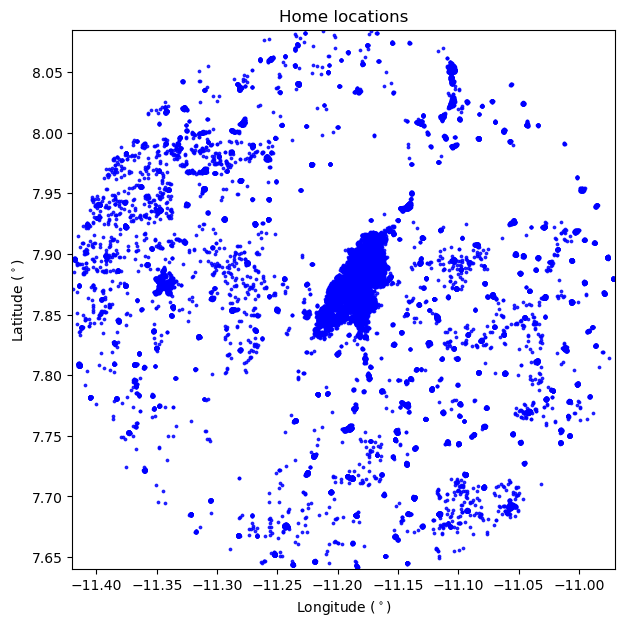

In [11]:
# Plot home locations
plt.figure(figsize=(7, 7))
plt.title('Home locations')
plt.scatter(x=coords[:, 0], y=coords[:, 1],color='b', s=3, alpha=0.8)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
axes = plt.gca()
axes.set_xlim([min(coords[:, 0]) - 0.001, max(coords[:, 0]) + 0.001])
axes.set_ylim([min(coords[:, 1]) - 0.001, max(coords[:, 1]) + 0.001])

In [39]:
# Cluster the data
# TODO See how the parameters affect the result.

clust = OPTICS(min_samples=150, xi=0.5, min_cluster_size=.05)

# Run the fit
clust.fit(coords)
labelsOp = clust.labels_[clust.ordering_]

[[   -1 18749]
 [    0  1276]
 [    1 21914]
 [    2   411]
 [    3   415]
 [    4   454]
 [    5   531]]


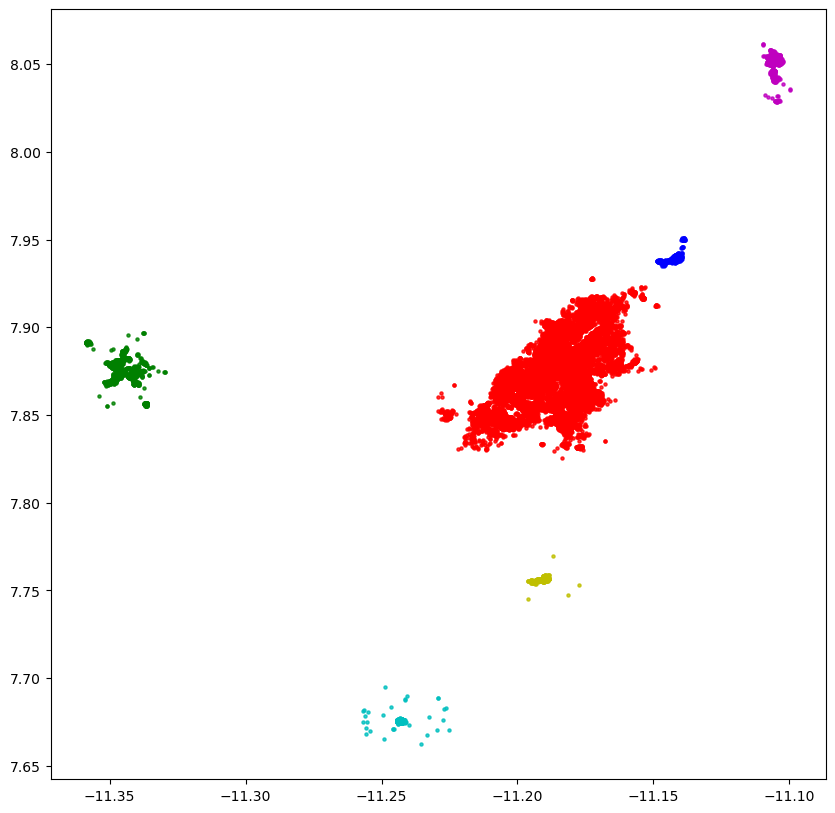

In [38]:
# TODO Now change range by changing eps in the DBSCAN equivalent.

labelsF = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.0125)

# See how many houses in each cluster. -1 = outlier
(unique, counts) = np.unique(labelsF, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)


plt.figure(figsize=(10, 10))

colors = ['g', 'r', 'b', 'y', 'c','m','olive','b','m','cyan','pink','lime','salmon']
labels = labelsF
for klass, color in zip(range(0, 12), colors):
    plt.scatter(x=coords[labels == klass, 0], y=coords[labels == klass, 1],color=color, s=5, alpha=0.8)

# plot outliers
plt.scatter(x=coords[clust.labels_ == -1, 0], y=coords[clust.labels_ == -1, 1],color='k', s=1, alpha=0.8)

In [29]:
# Haversine formula for kilometer distance between two lat/long points
def haversine_dist_from_coords(lat1, lon1, lat2, lon2):
    # The math module contains a function named radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
    # calculate and return the result
    return c * r

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  1984
Number of edges in the minimum spanning tree:  1983
Total distance of minimum spanning tree (in km):  95.98361533074562
Plotting results:


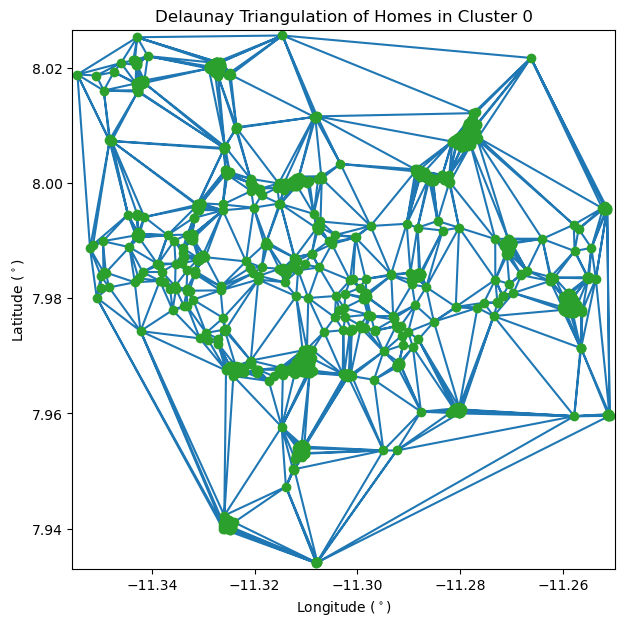

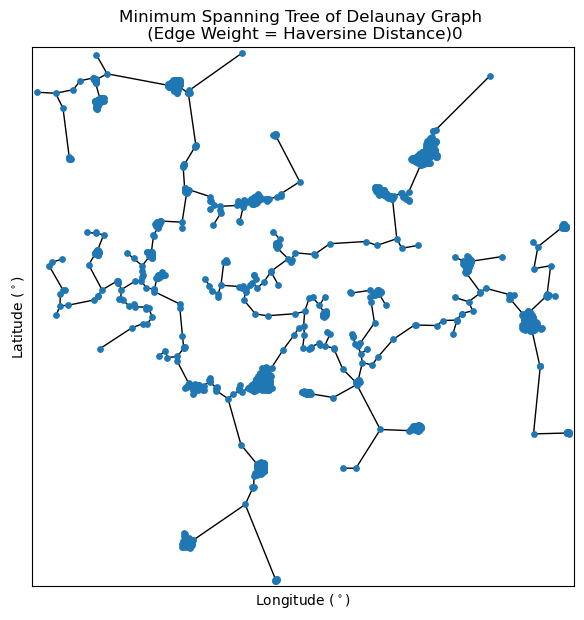

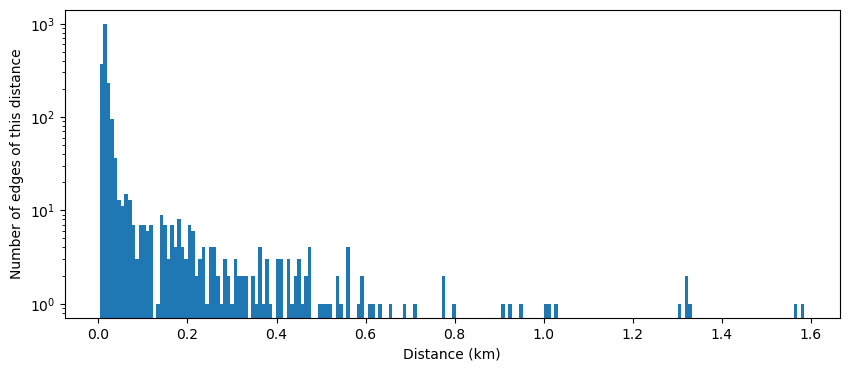

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  1269
Number of edges in the minimum spanning tree:  1268
Total distance of minimum spanning tree (in km):  91.02009195712486
Plotting results:


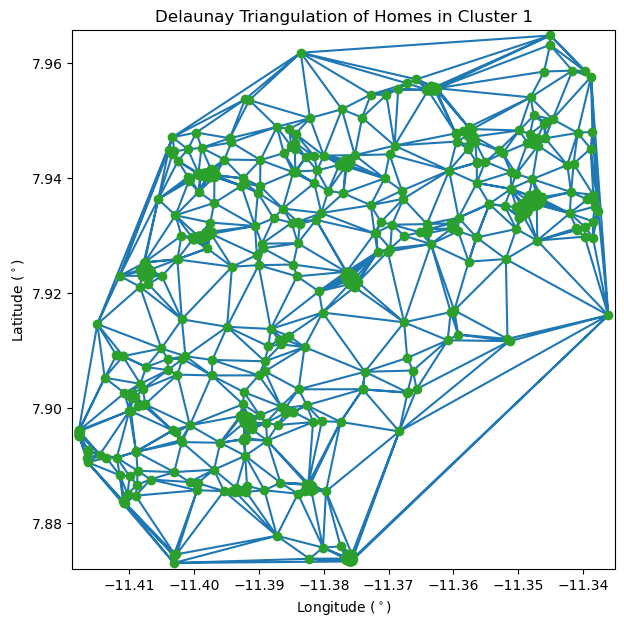

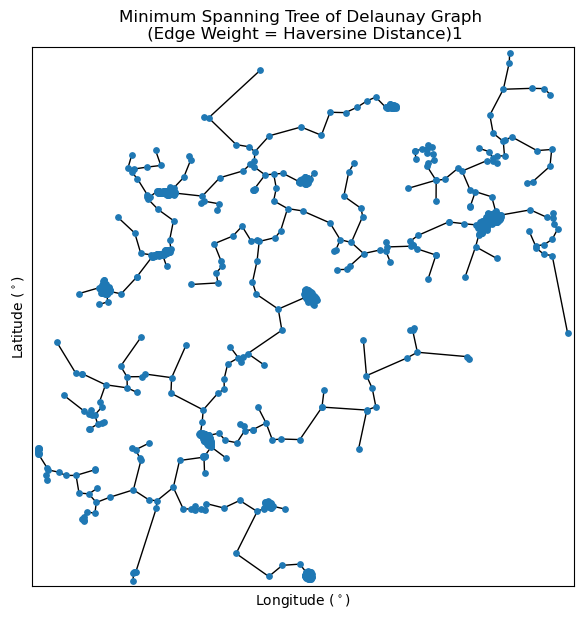

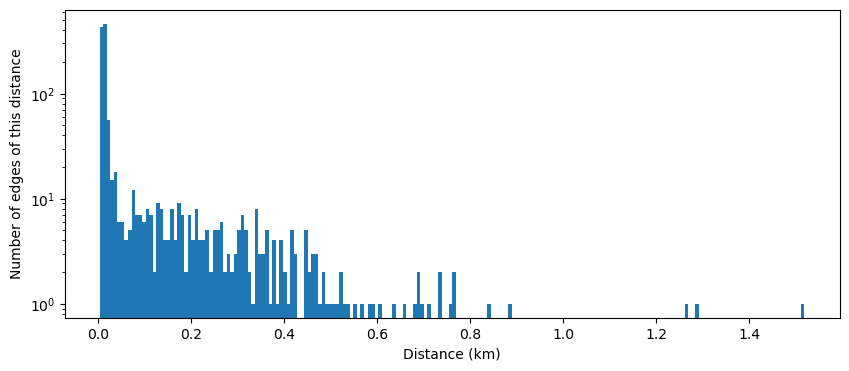

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  189
Number of edges in the minimum spanning tree:  188
Total distance of minimum spanning tree (in km):  10.578898199074194
Plotting results:


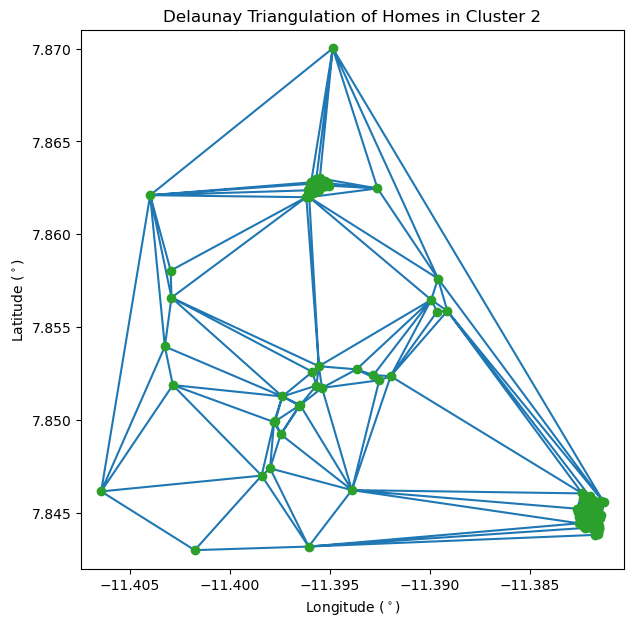

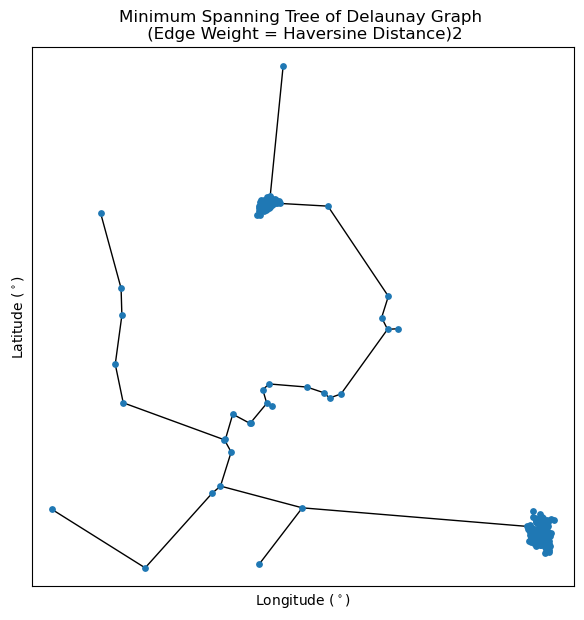

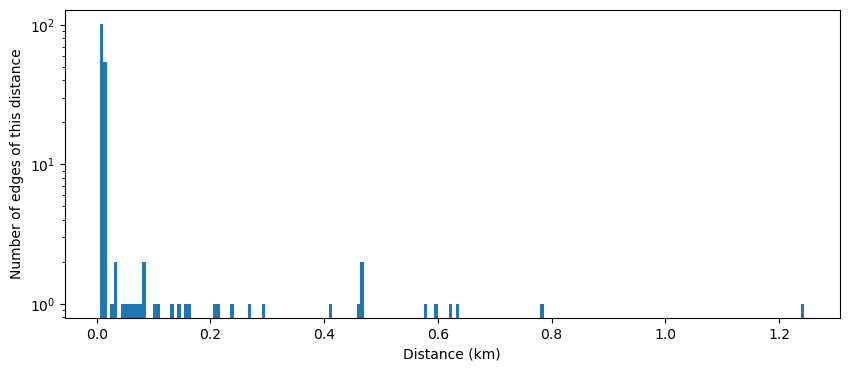

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  65
Number of edges in the minimum spanning tree:  64
Total distance of minimum spanning tree (in km):  3.4296185067704035
Plotting results:


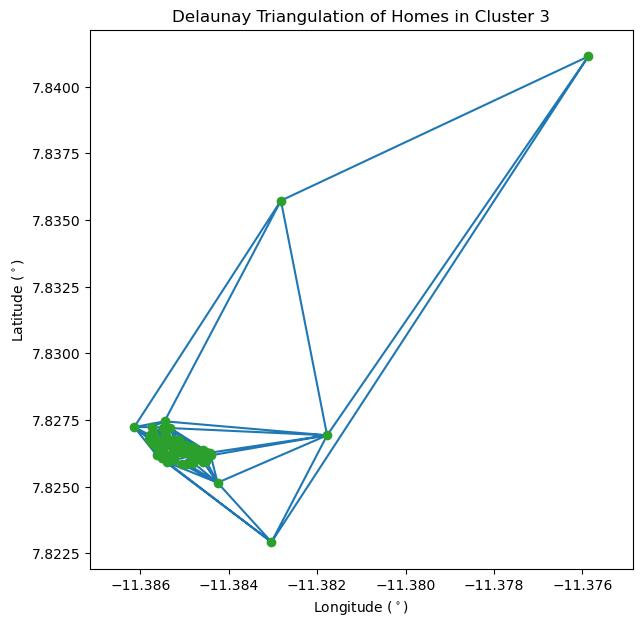

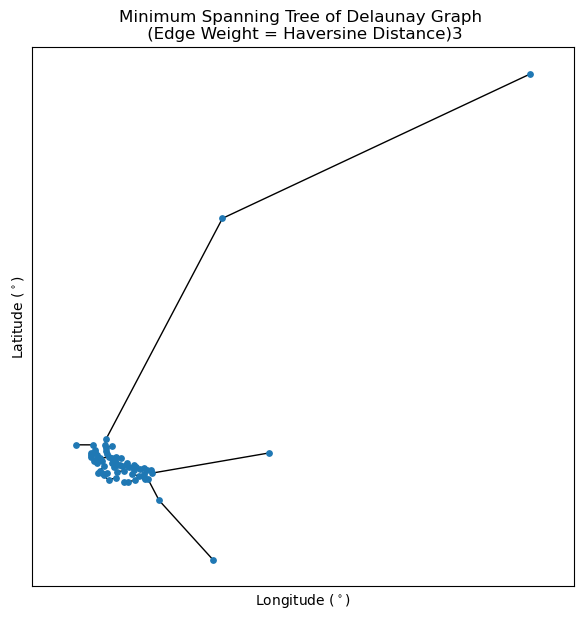

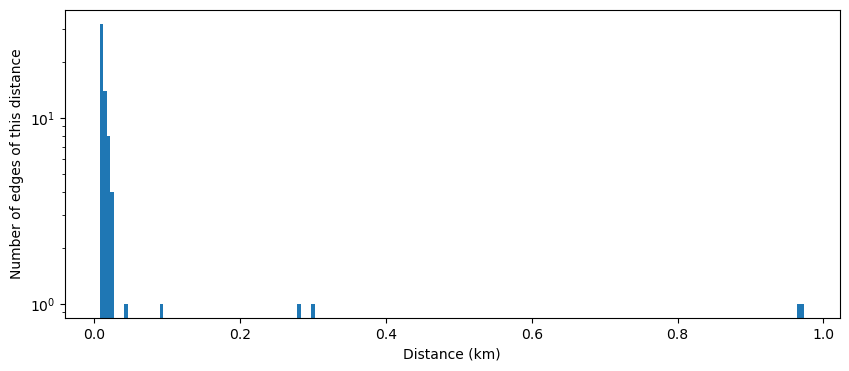

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  1393
Number of edges in the minimum spanning tree:  1392
Total distance of minimum spanning tree (in km):  48.3219291833628
Plotting results:


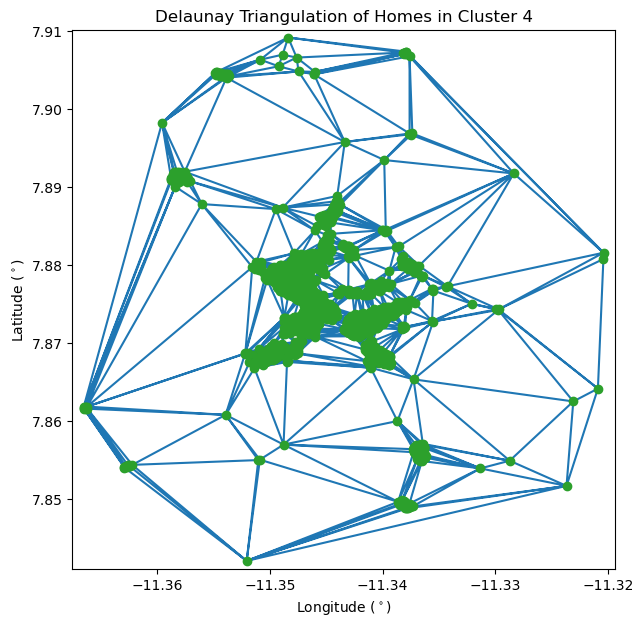

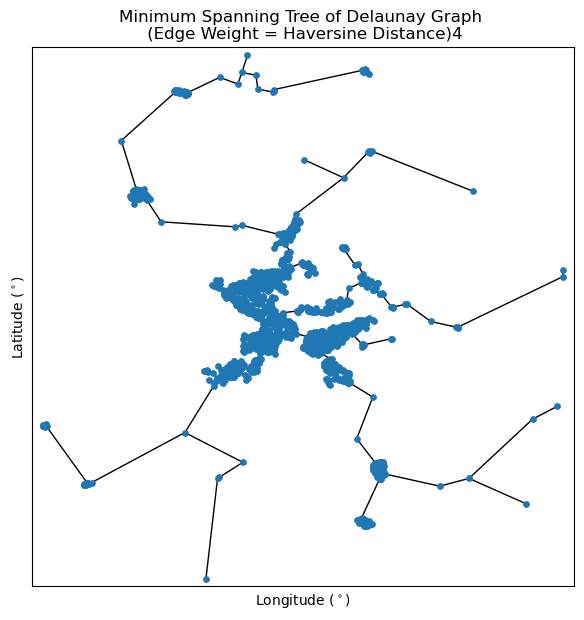

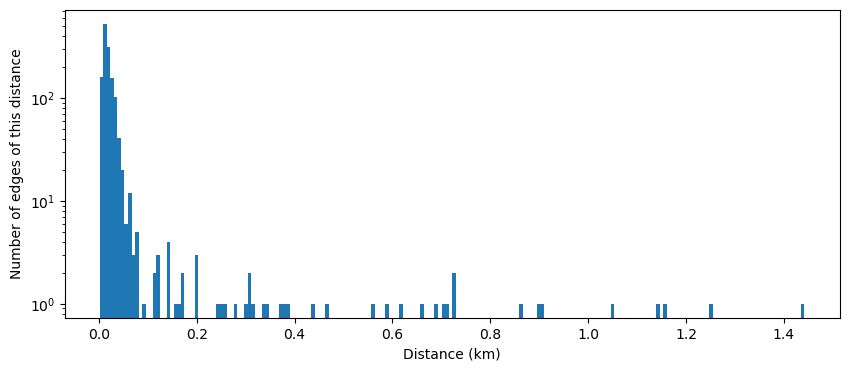

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  231
Number of edges in the minimum spanning tree:  230
Total distance of minimum spanning tree (in km):  20.553380614540618
Plotting results:


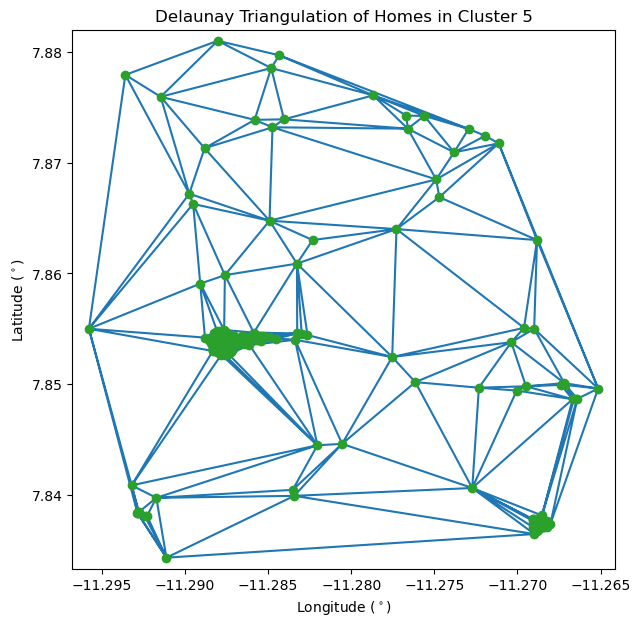

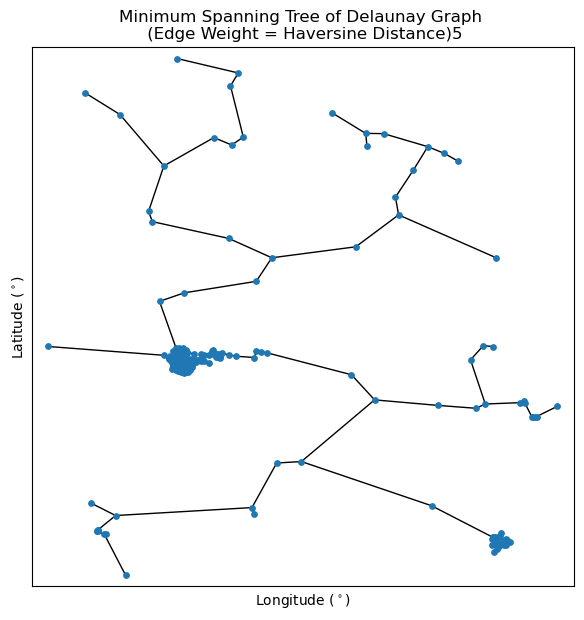

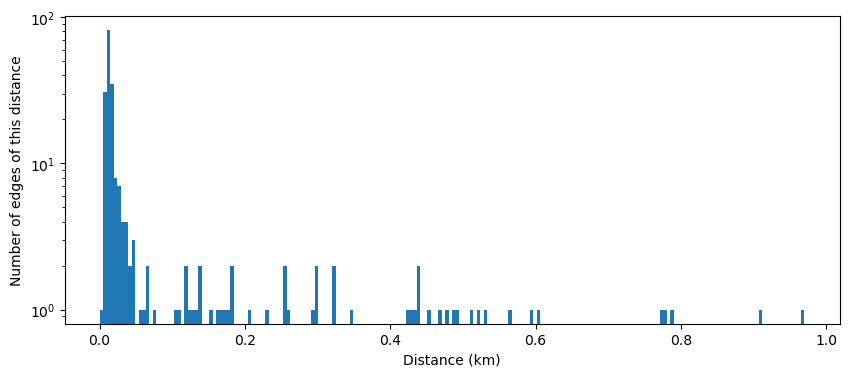

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  170
Number of edges in the minimum spanning tree:  169
Total distance of minimum spanning tree (in km):  17.21870508398704
Plotting results:


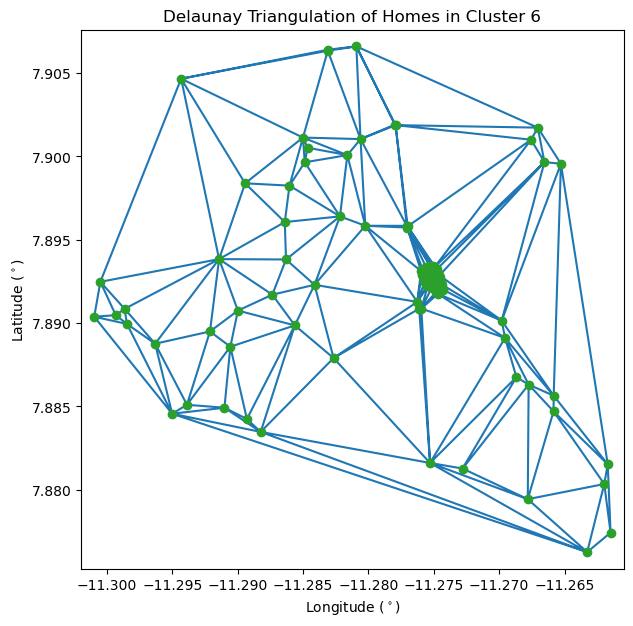

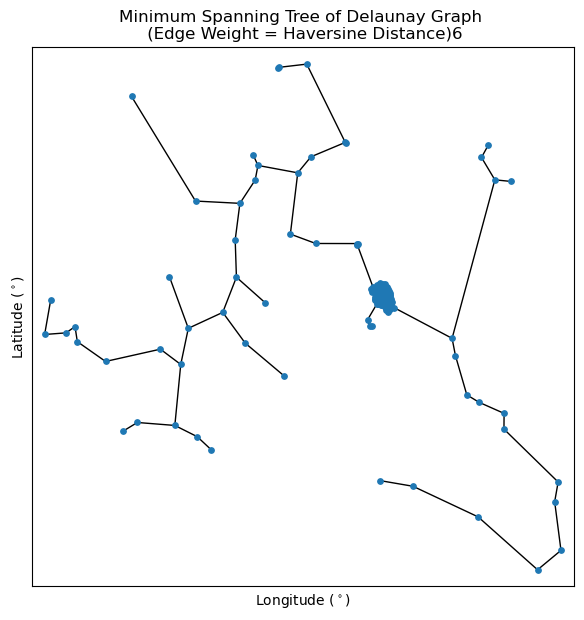

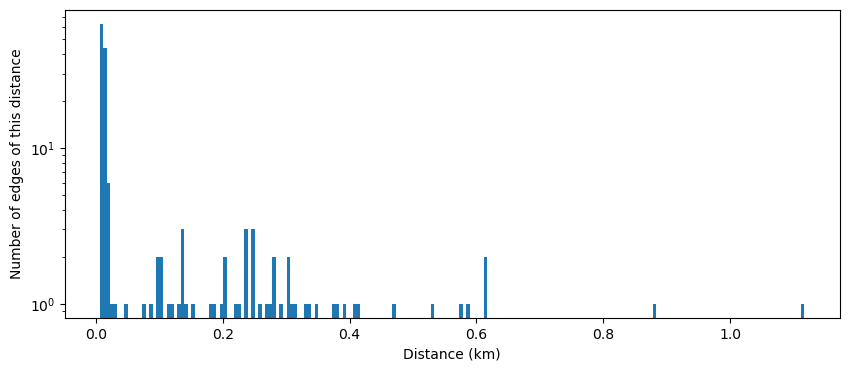

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  22801
Number of edges in the minimum spanning tree:  22800
Total distance of minimum spanning tree (in km):  523.6893644743643
Plotting results:


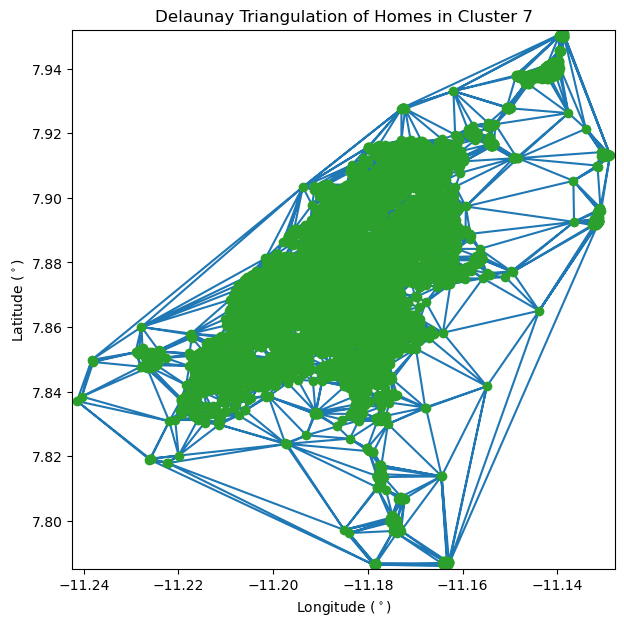

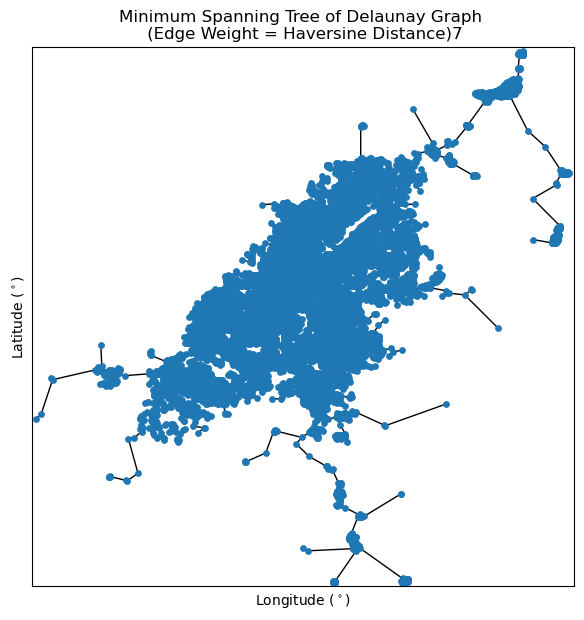

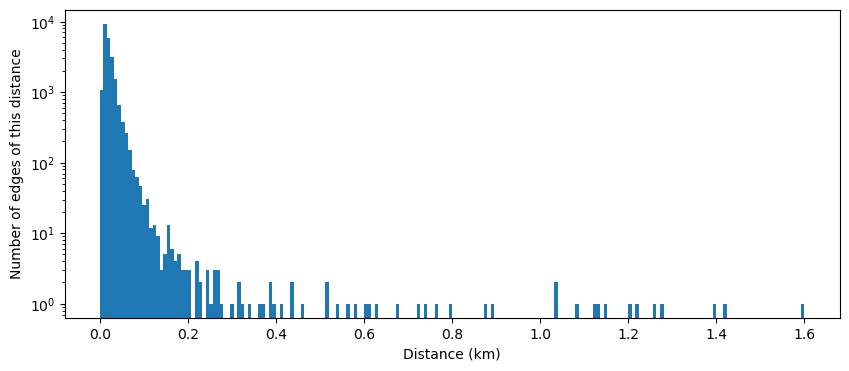

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  577
Number of edges in the minimum spanning tree:  576
Total distance of minimum spanning tree (in km):  17.32903666706398
Plotting results:


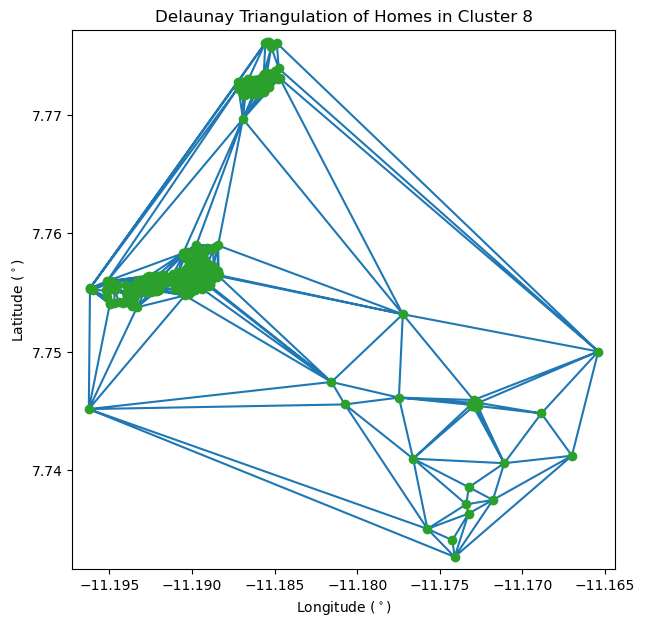

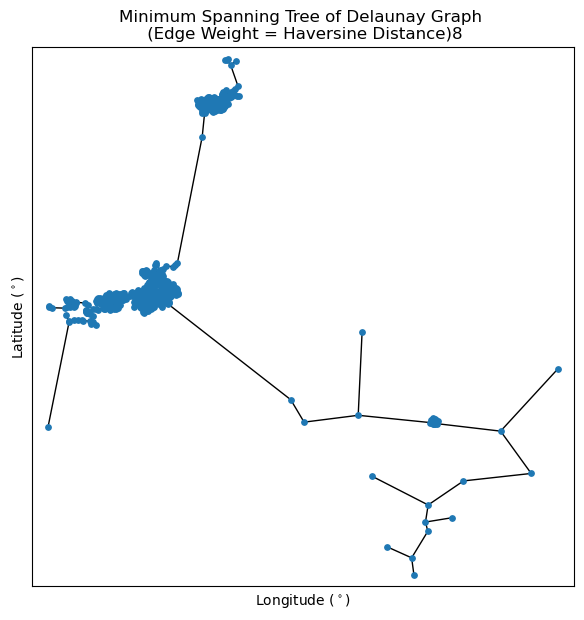

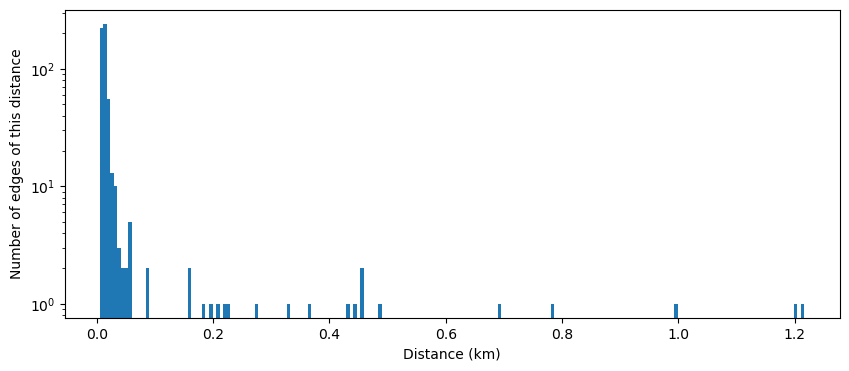

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  382
Number of edges in the minimum spanning tree:  381
Total distance of minimum spanning tree (in km):  13.156048683629901
Plotting results:


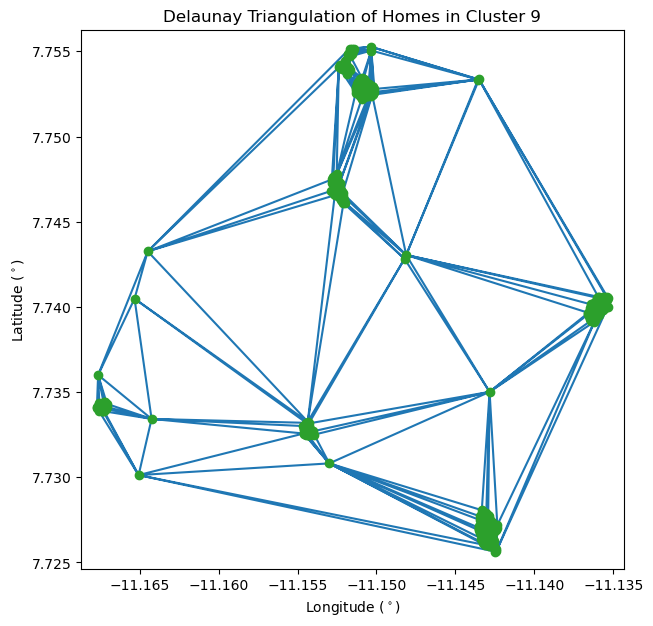

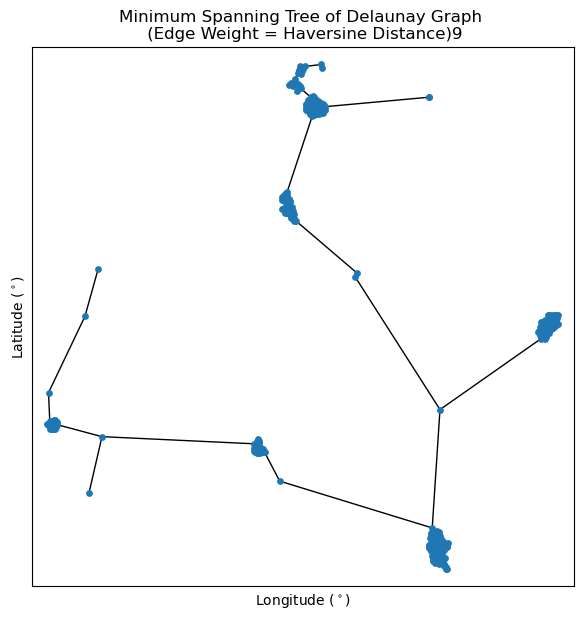

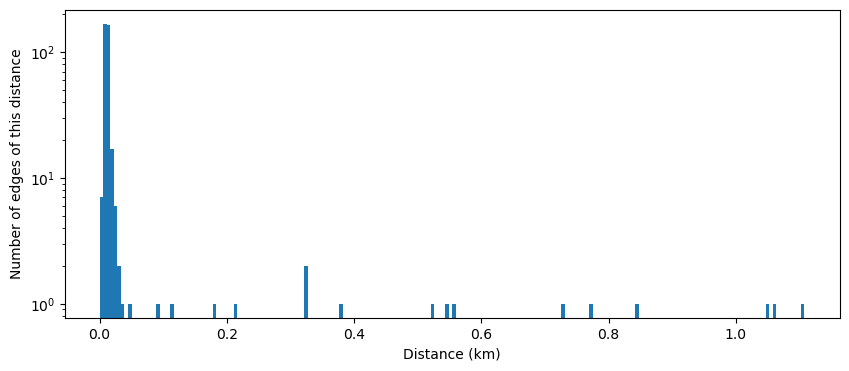

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  206
Number of edges in the minimum spanning tree:  205
Total distance of minimum spanning tree (in km):  8.193513885089882
Plotting results:


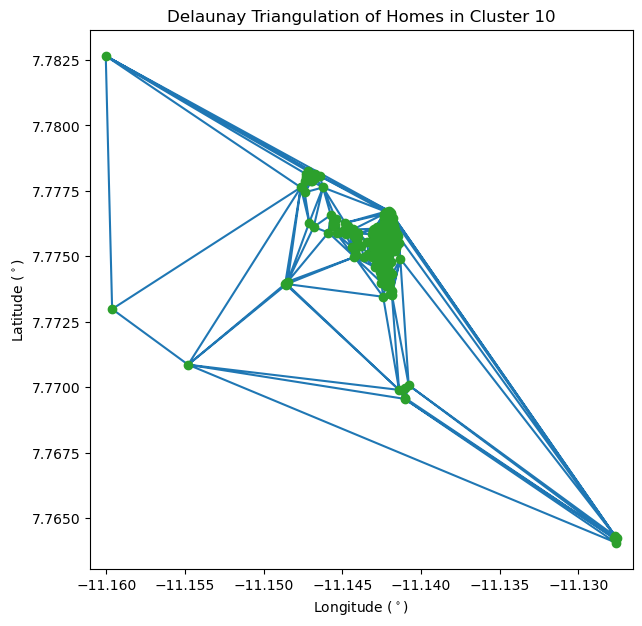

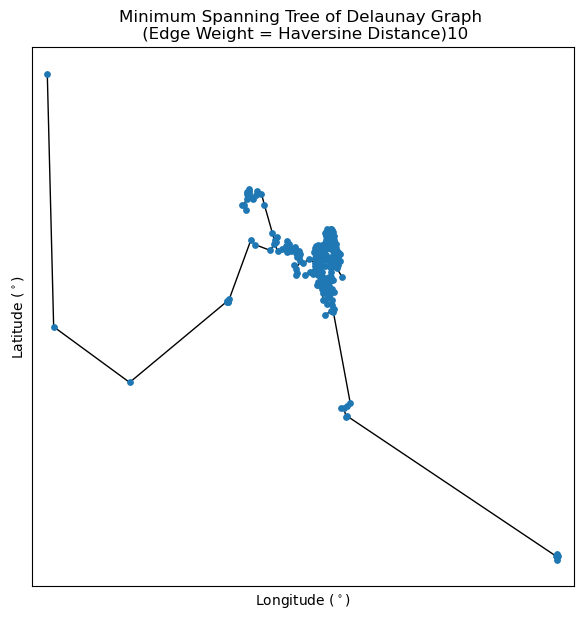

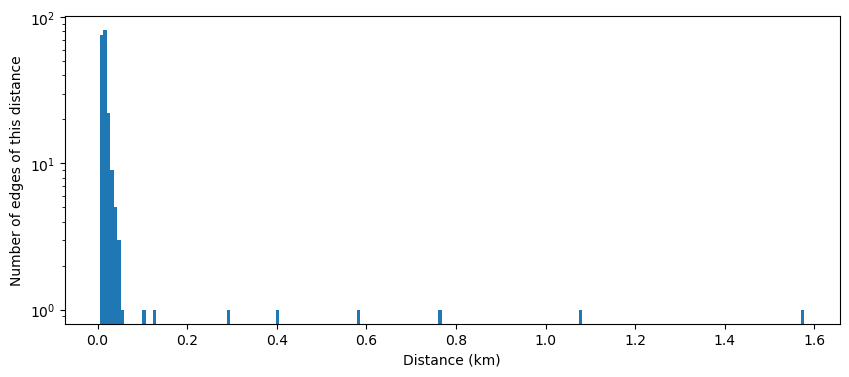

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  1402
Number of edges in the minimum spanning tree:  1401
Total distance of minimum spanning tree (in km):  72.05918736600114
Plotting results:


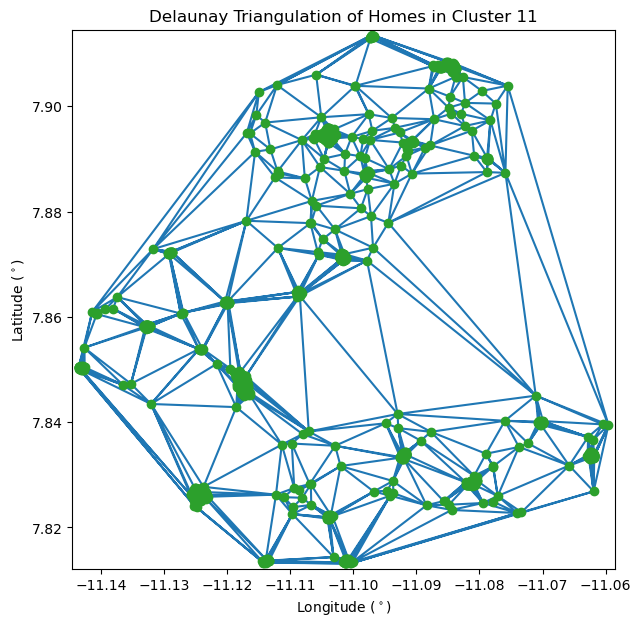

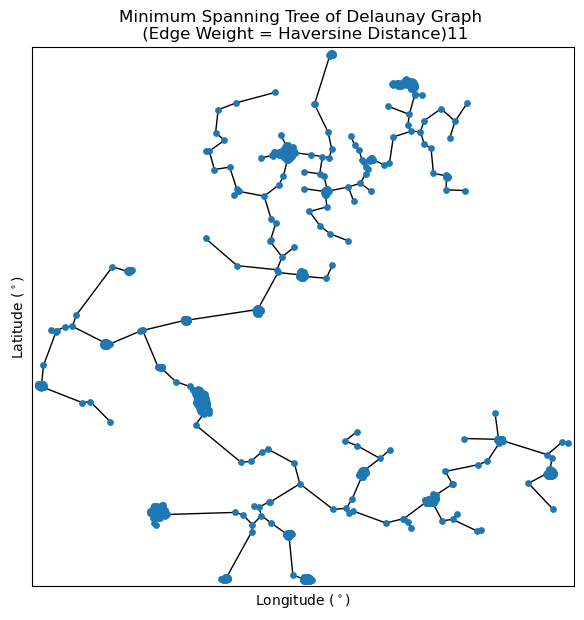

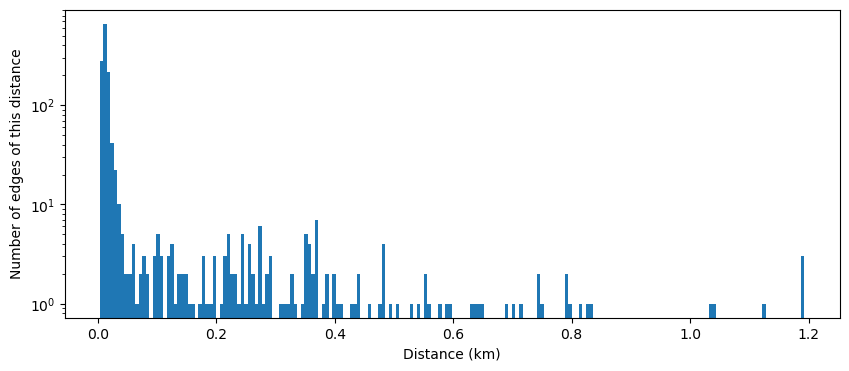

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  55
Number of edges in the minimum spanning tree:  54
Total distance of minimum spanning tree (in km):  4.162996069899872
Plotting results:


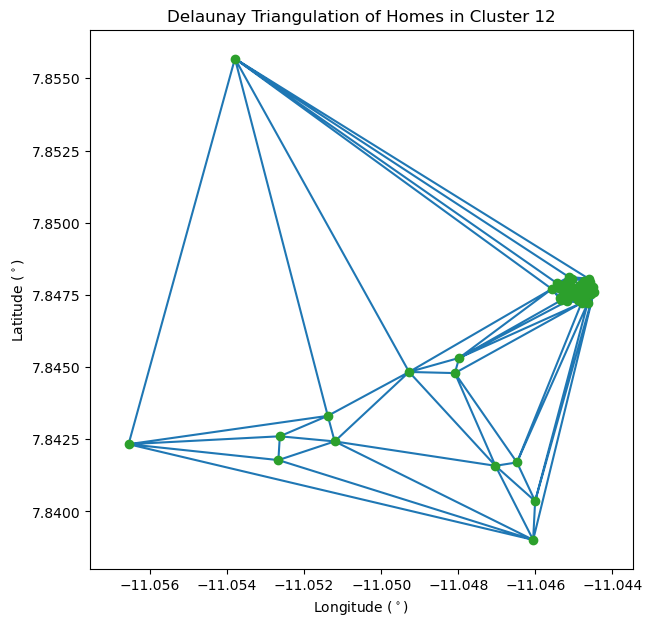

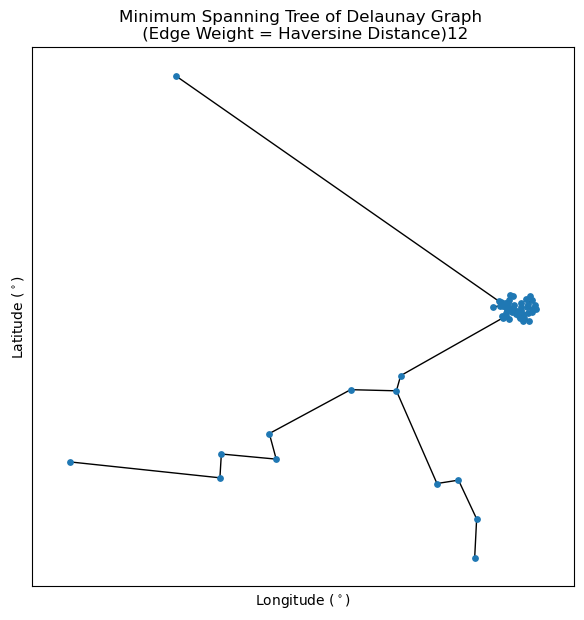

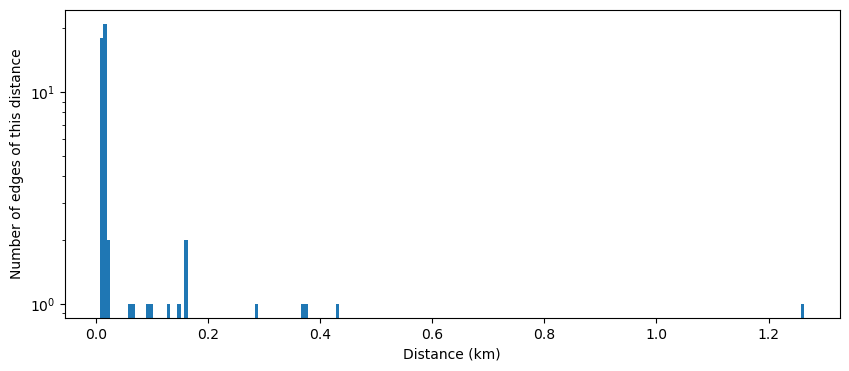

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  223
Number of edges in the minimum spanning tree:  222
Total distance of minimum spanning tree (in km):  7.520464782031622
Plotting results:


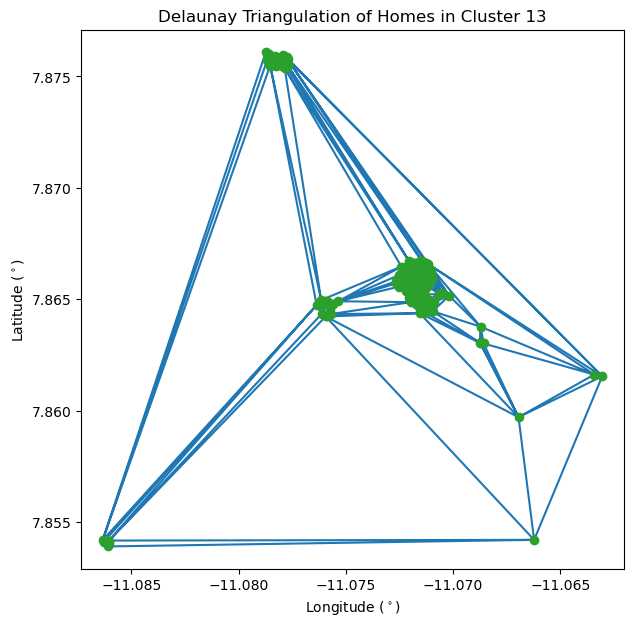

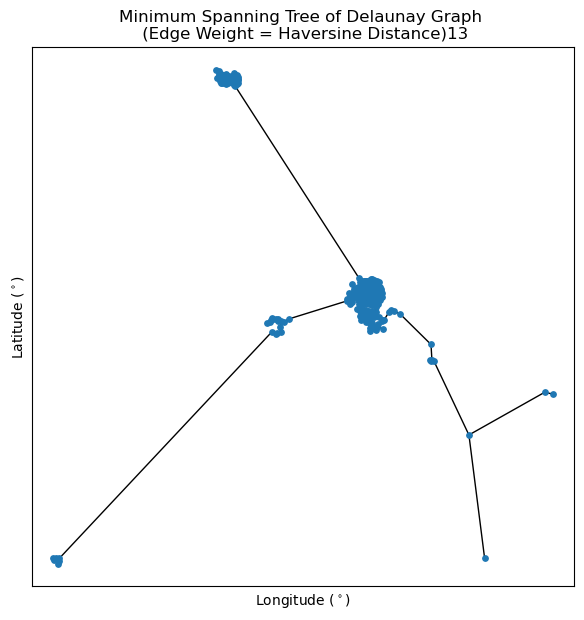

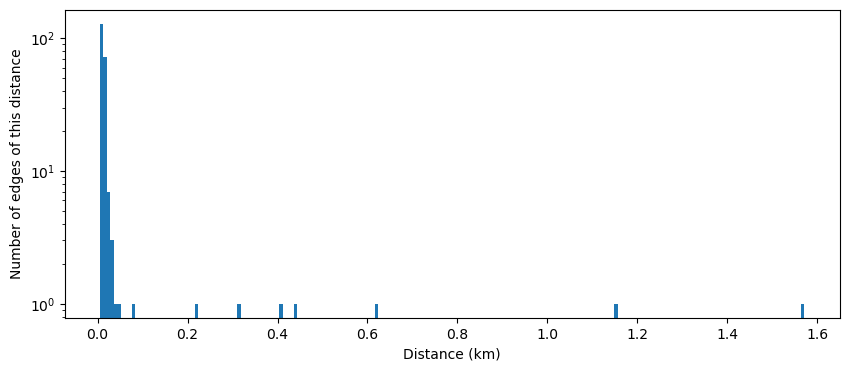

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  290
Number of edges in the minimum spanning tree:  289
Total distance of minimum spanning tree (in km):  12.27671647402441
Plotting results:


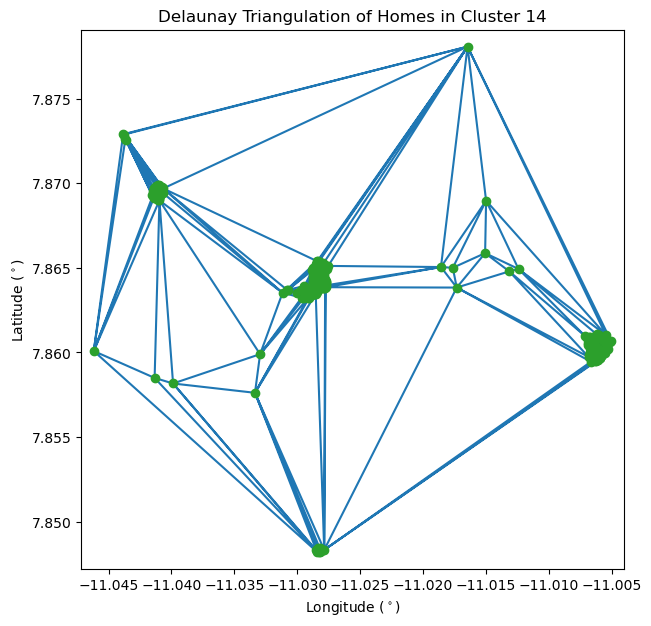

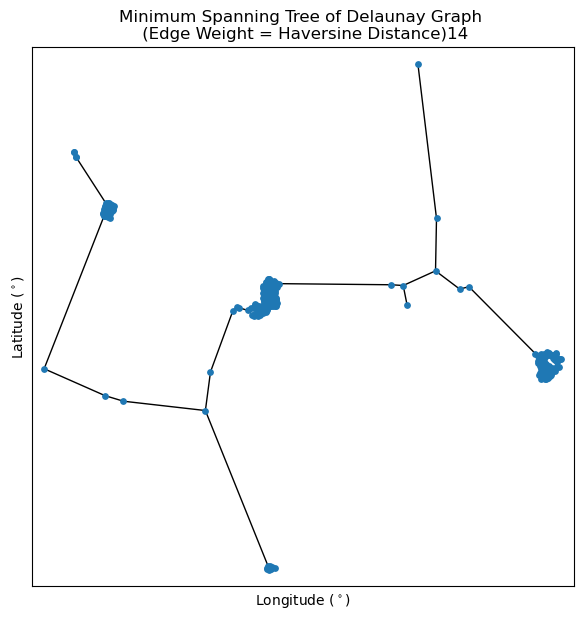

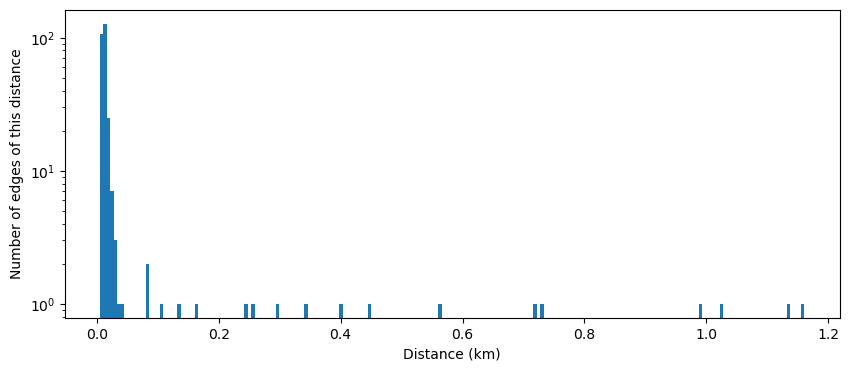

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  227
Number of edges in the minimum spanning tree:  226
Total distance of minimum spanning tree (in km):  9.130096030415167
Plotting results:


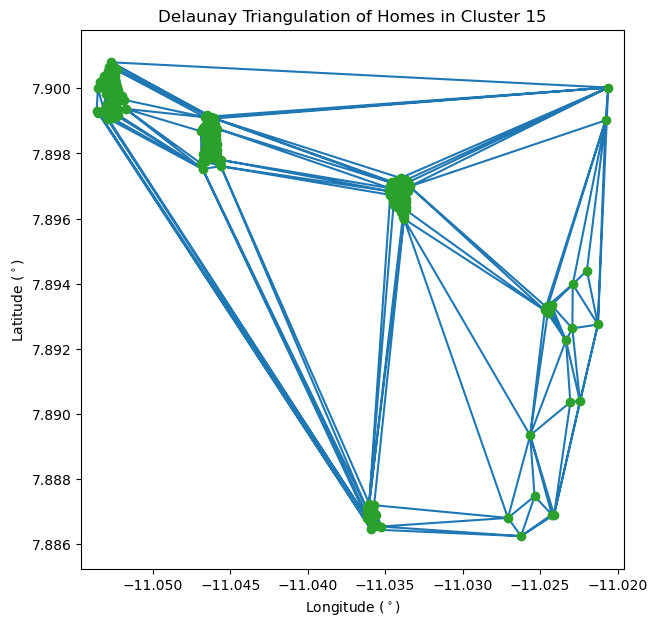

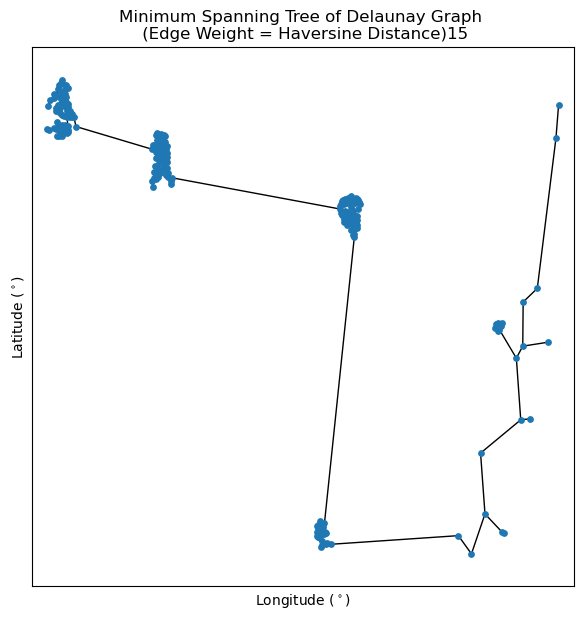

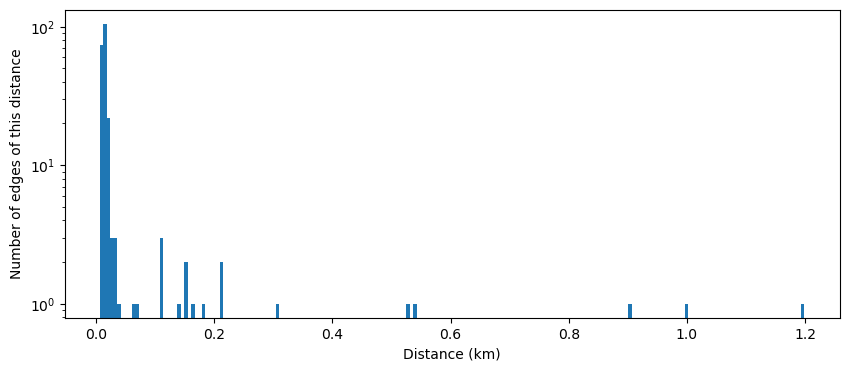

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  295
Number of edges in the minimum spanning tree:  294
Total distance of minimum spanning tree (in km):  12.649405455183706
Plotting results:


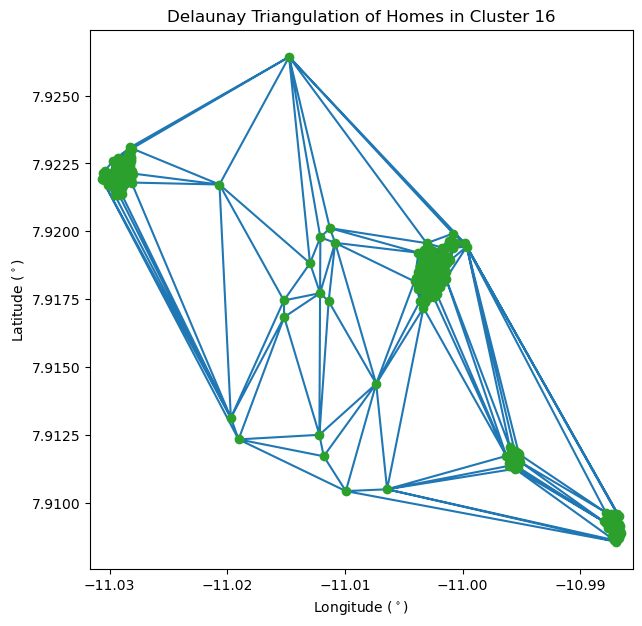

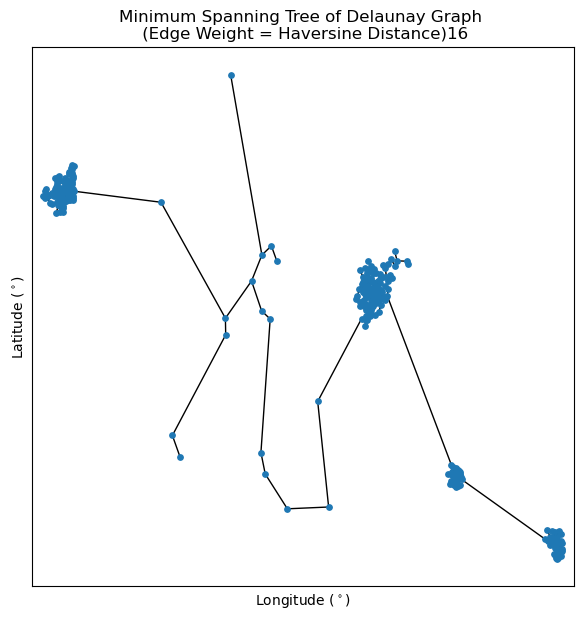

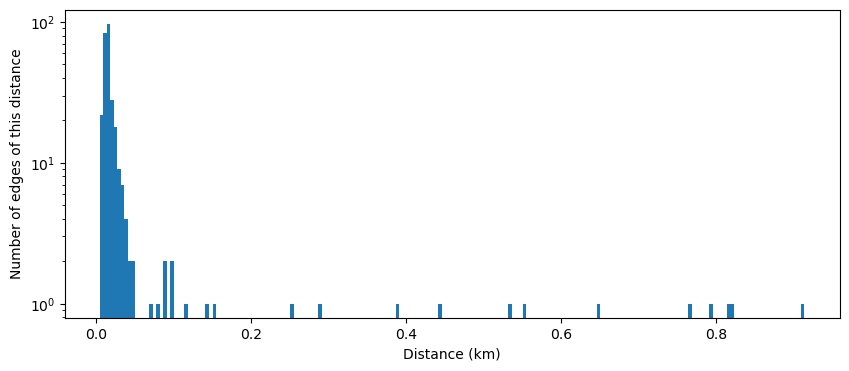

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  204
Number of edges in the minimum spanning tree:  203
Total distance of minimum spanning tree (in km):  4.451023366992474
Plotting results:


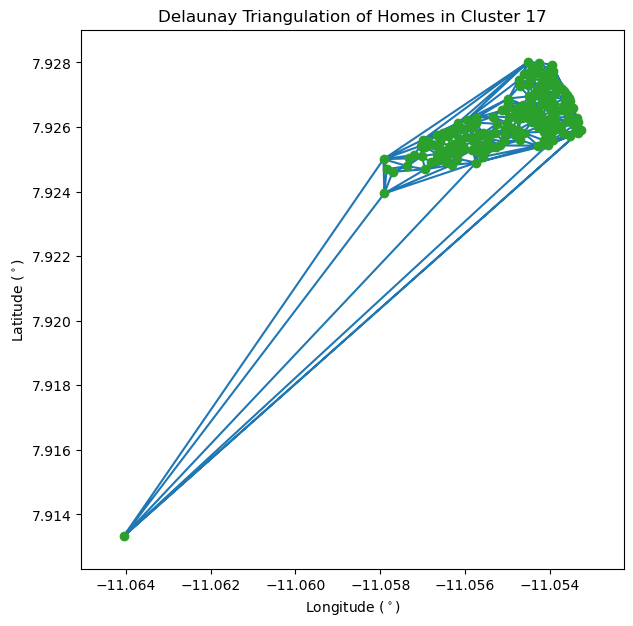

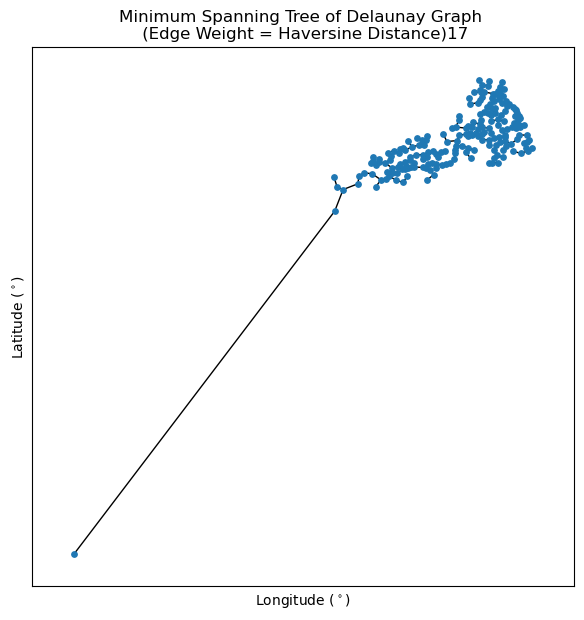

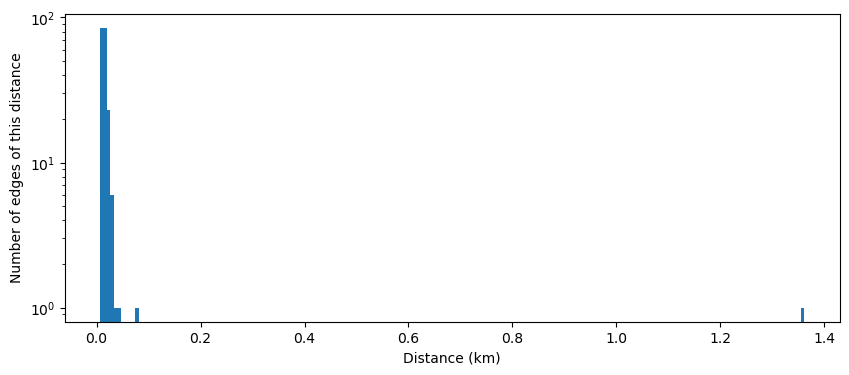

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  32
Number of edges in the minimum spanning tree:  31
Total distance of minimum spanning tree (in km):  1.4232913830398237
Plotting results:


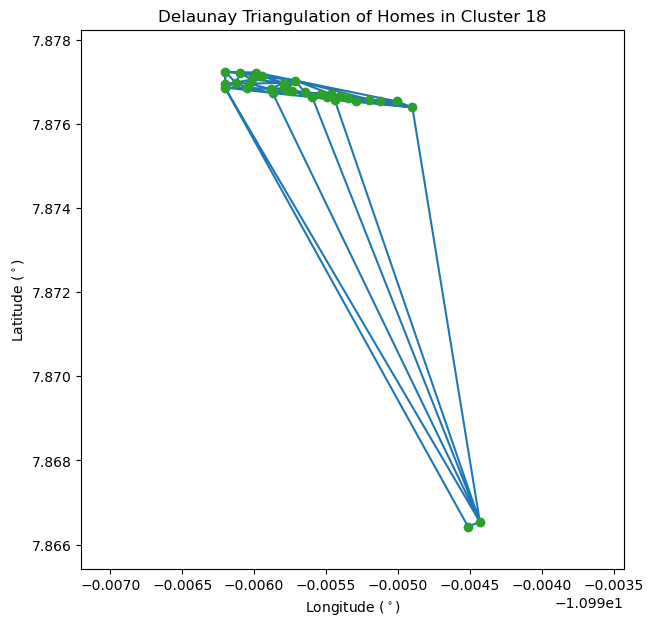

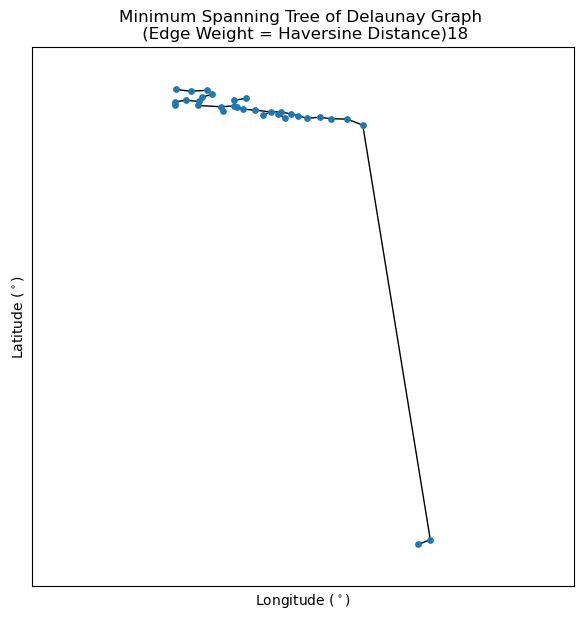

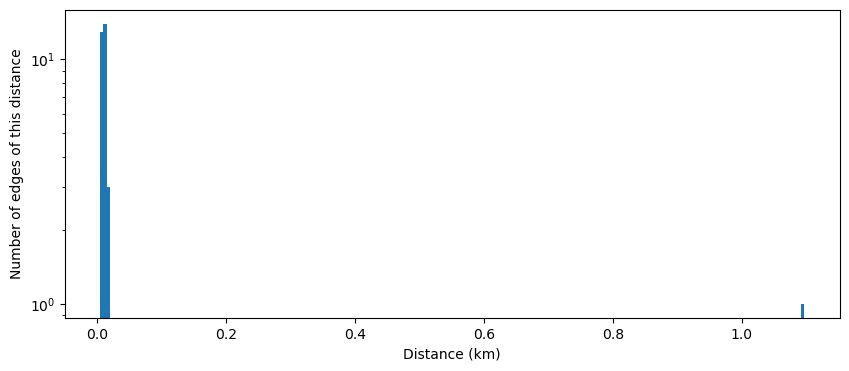

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  224
Number of edges in the minimum spanning tree:  223
Total distance of minimum spanning tree (in km):  15.842165703026305
Plotting results:


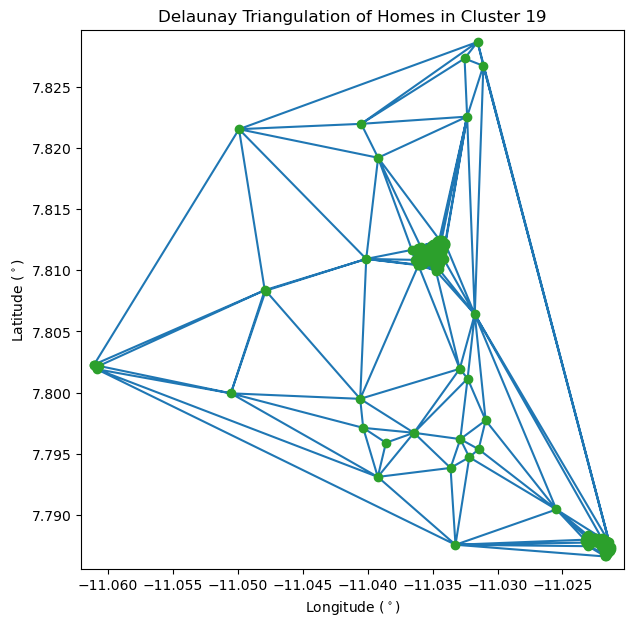

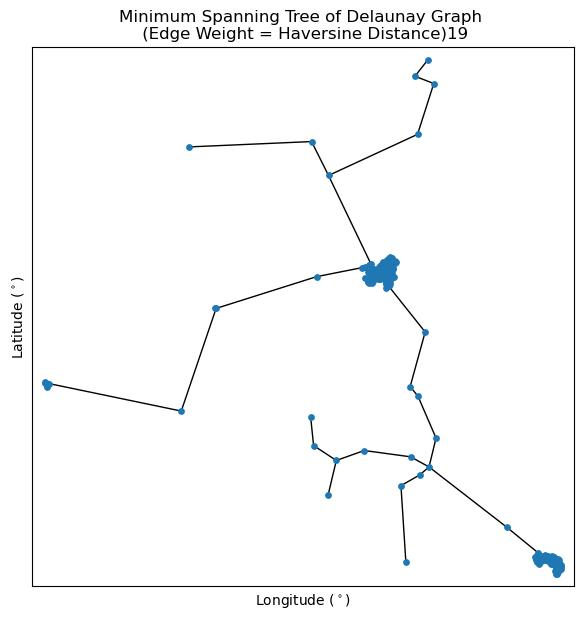

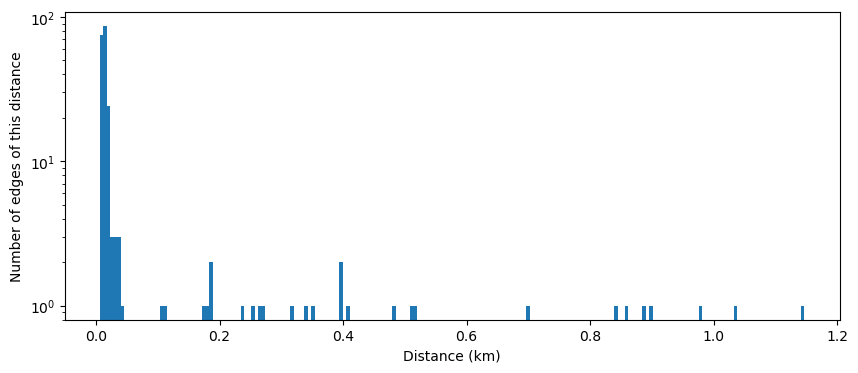

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  194
Number of edges in the minimum spanning tree:  193
Total distance of minimum spanning tree (in km):  6.364369628680919
Plotting results:


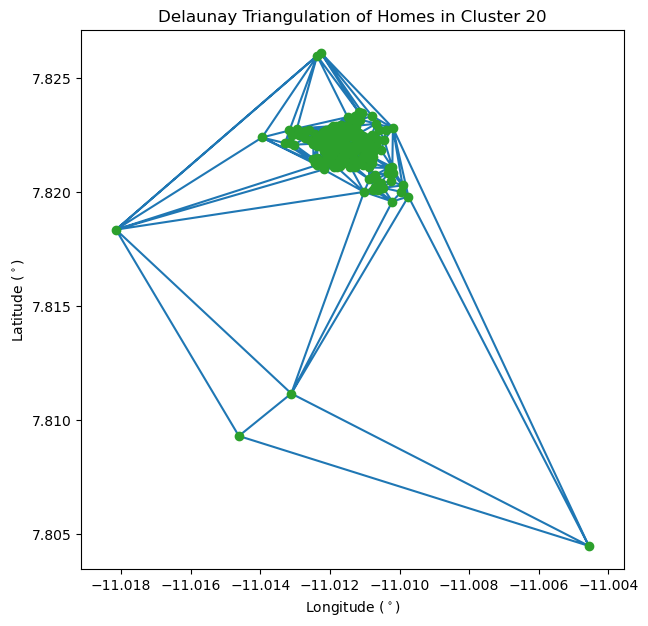

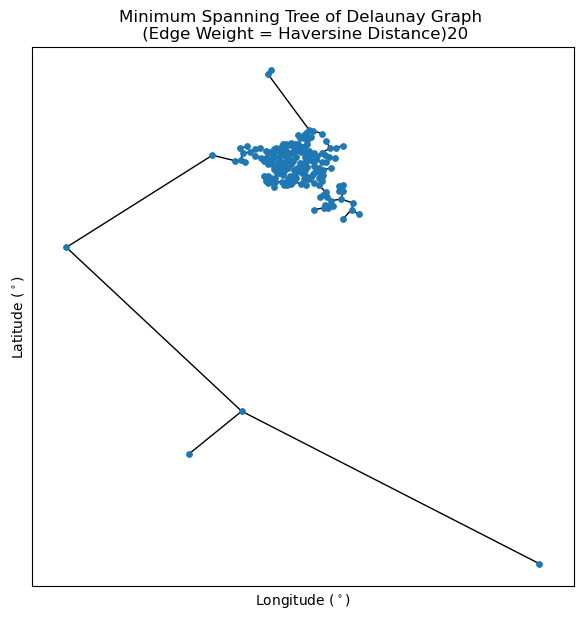

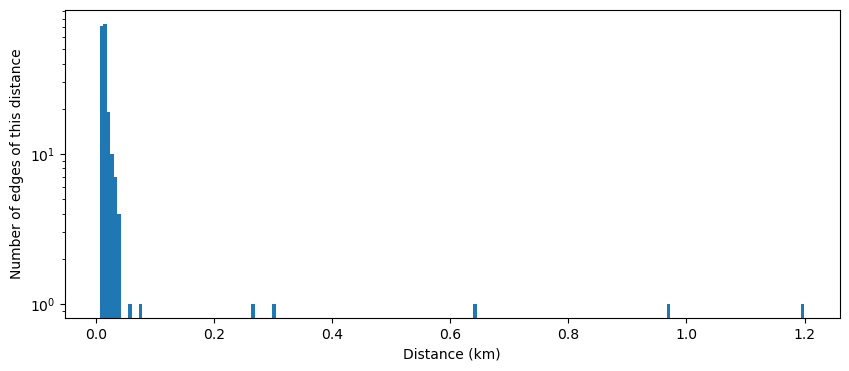

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  345
Number of edges in the minimum spanning tree:  344
Total distance of minimum spanning tree (in km):  16.136241268546563
Plotting results:


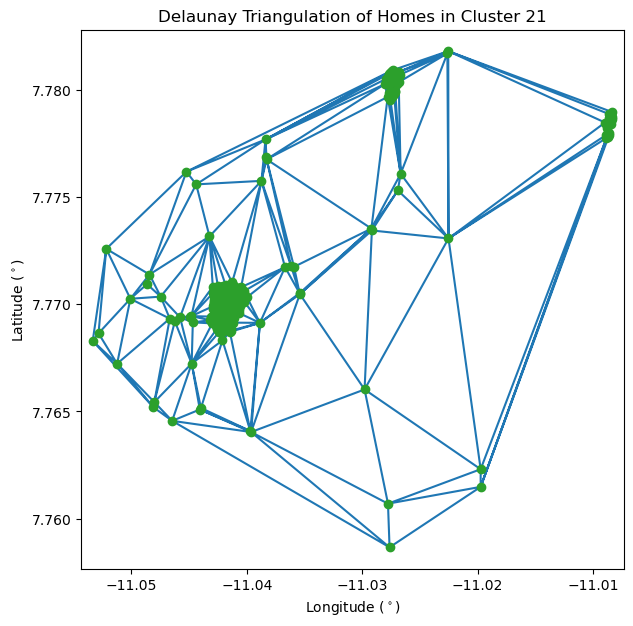

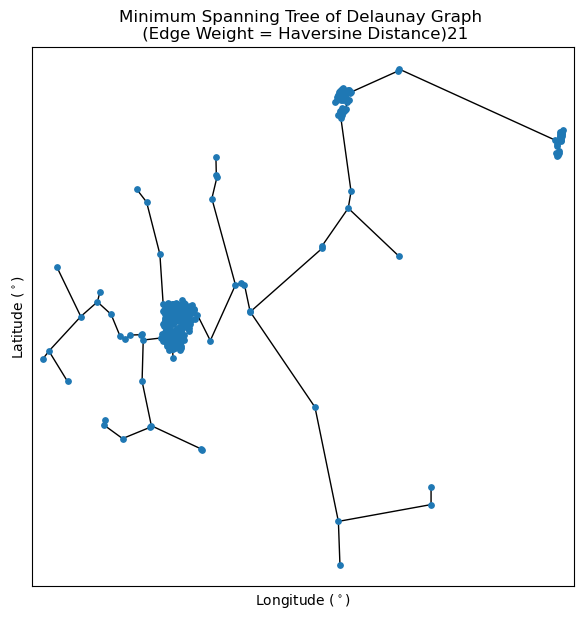

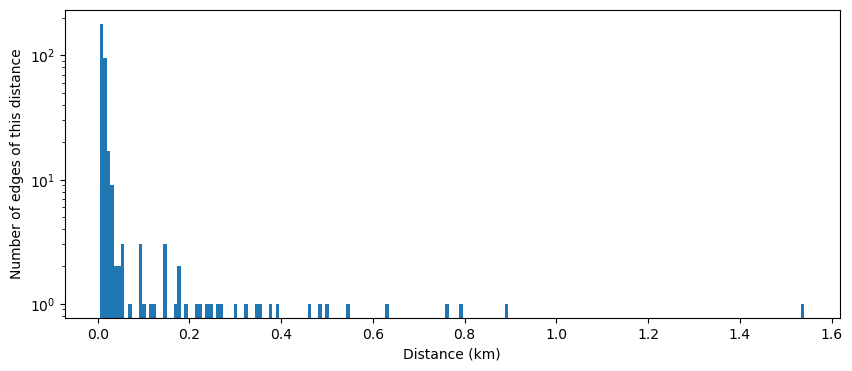

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  301
Number of edges in the minimum spanning tree:  300
Total distance of minimum spanning tree (in km):  13.220642331972746
Plotting results:


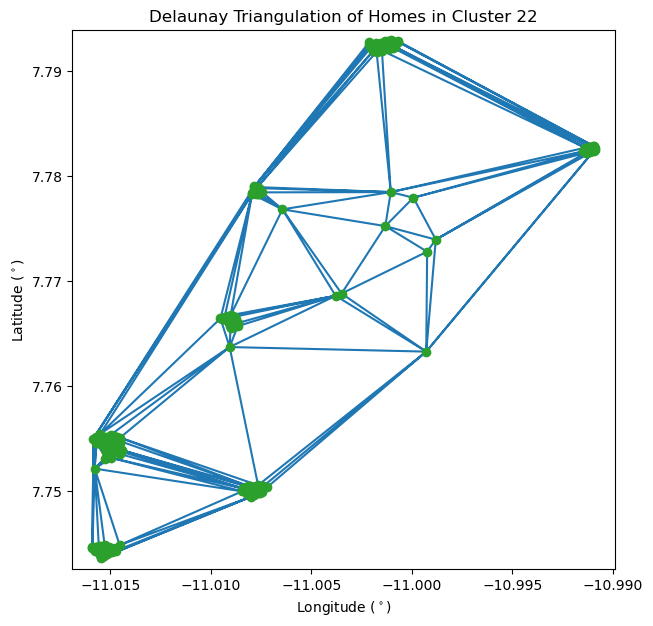

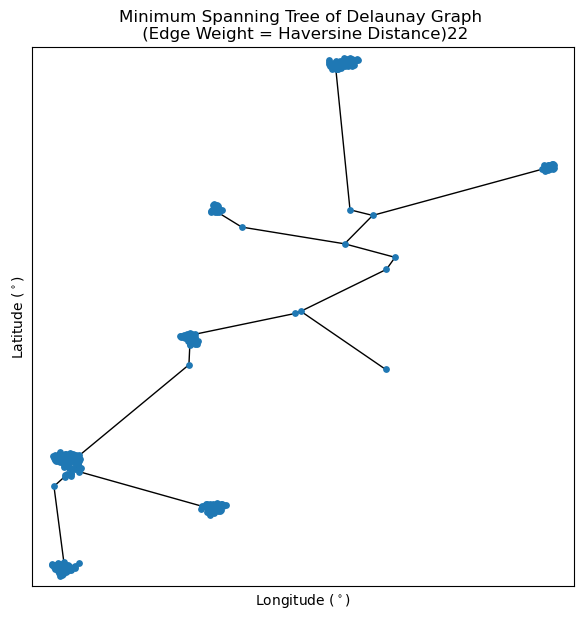

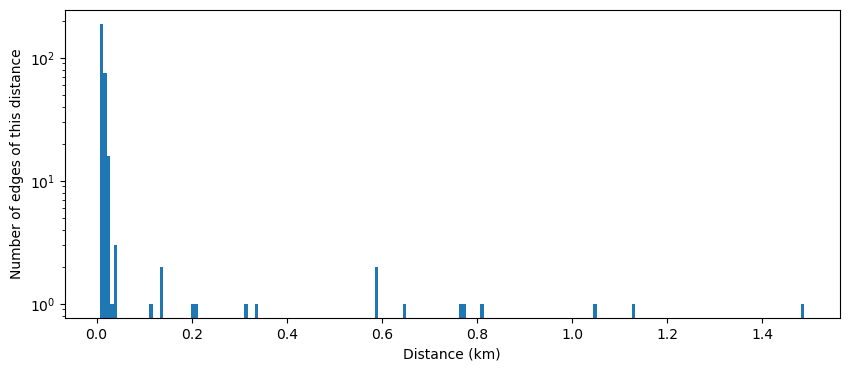

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  246
Number of edges in the minimum spanning tree:  245
Total distance of minimum spanning tree (in km):  11.47254696218309
Plotting results:


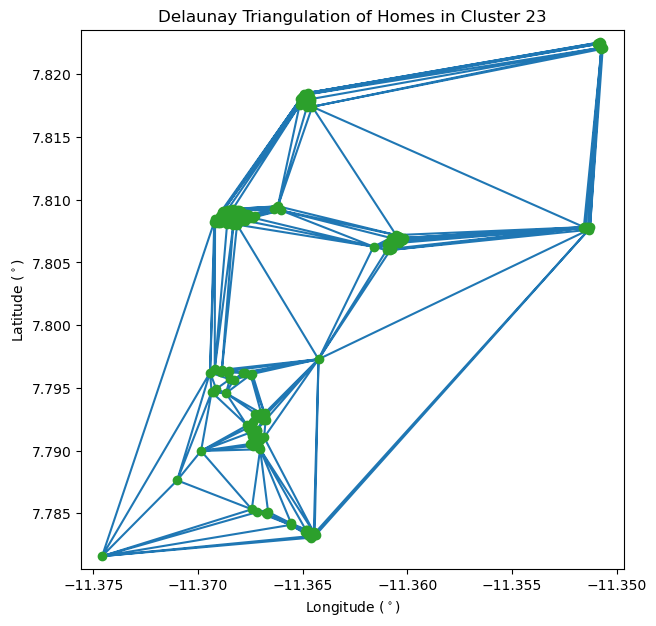

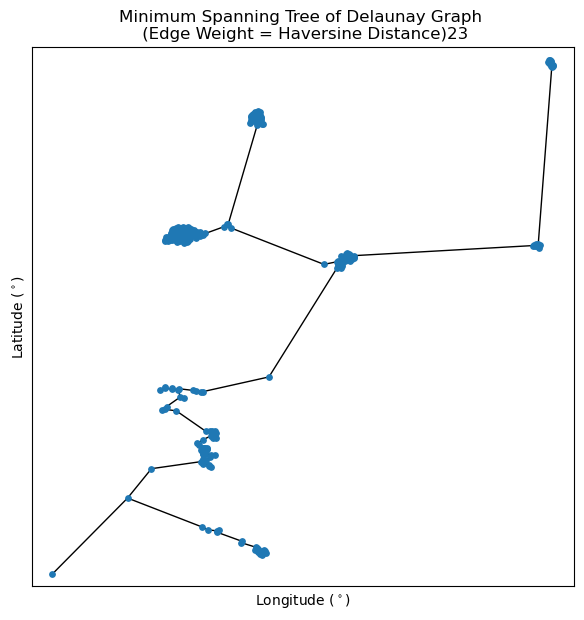

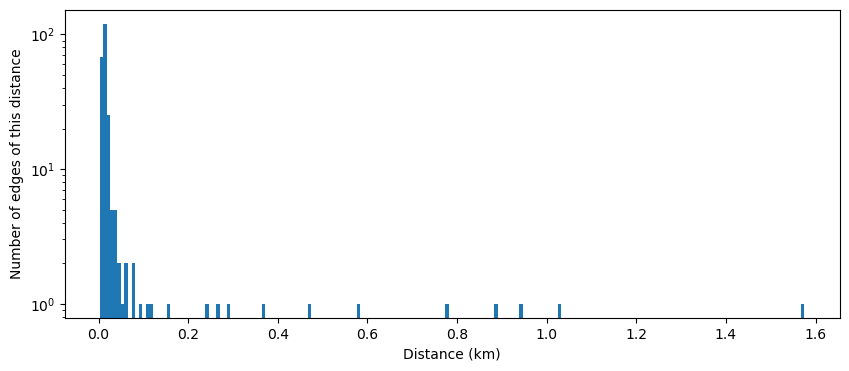

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  300
Number of edges in the minimum spanning tree:  299
Total distance of minimum spanning tree (in km):  14.452649643016407
Plotting results:


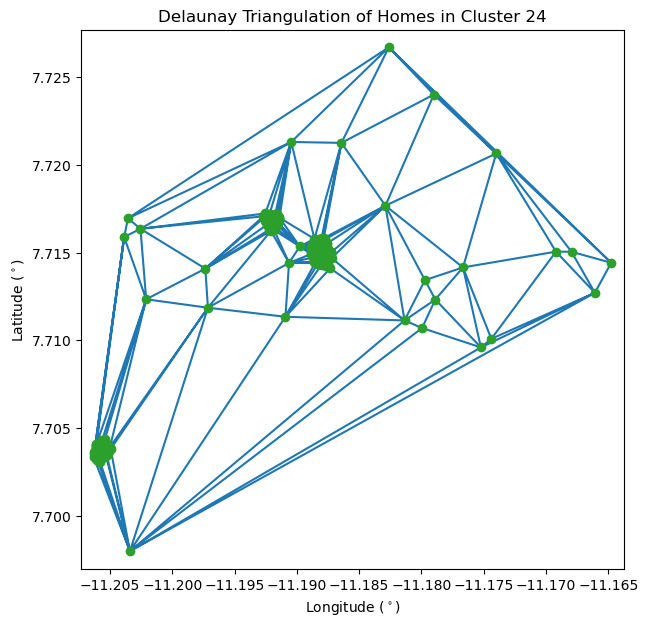

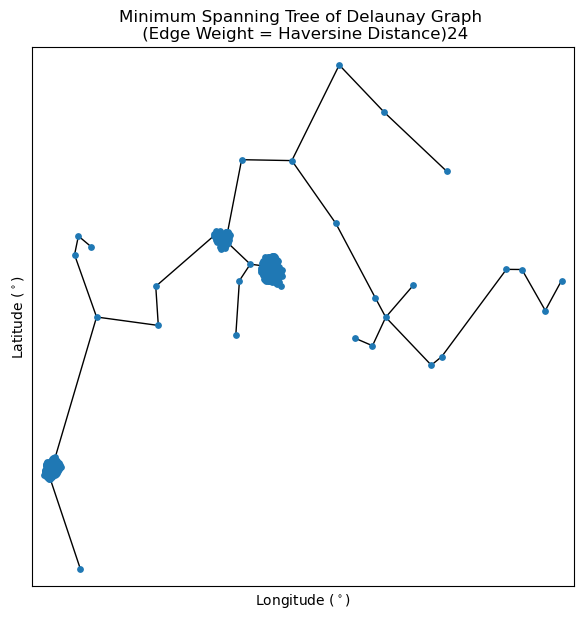

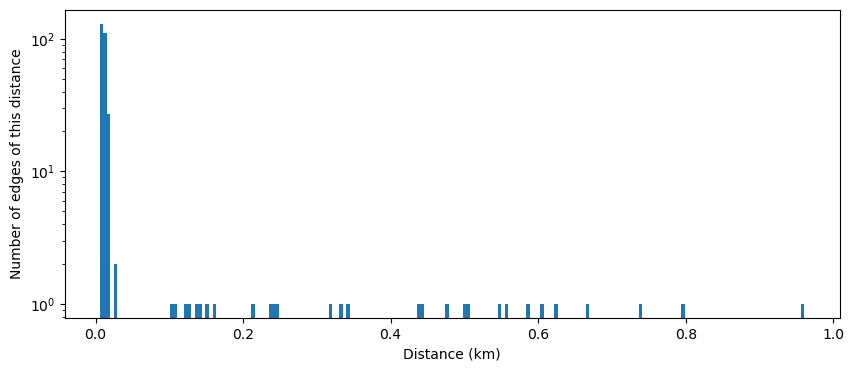

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  165
Number of edges in the minimum spanning tree:  164
Total distance of minimum spanning tree (in km):  8.435271108232019
Plotting results:


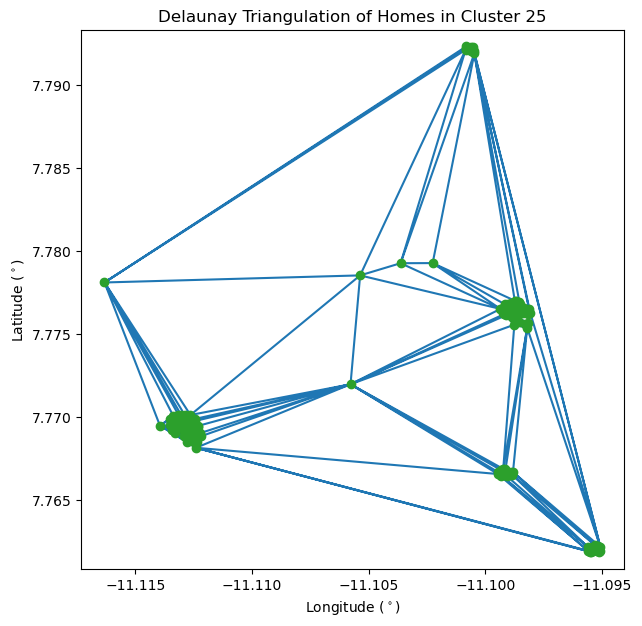

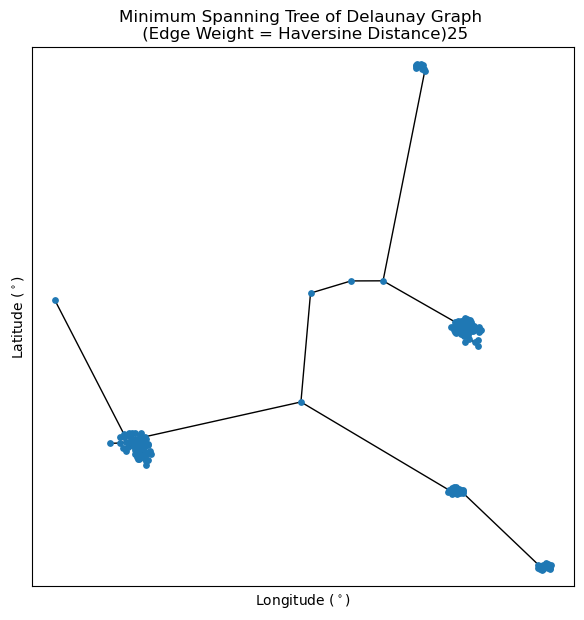

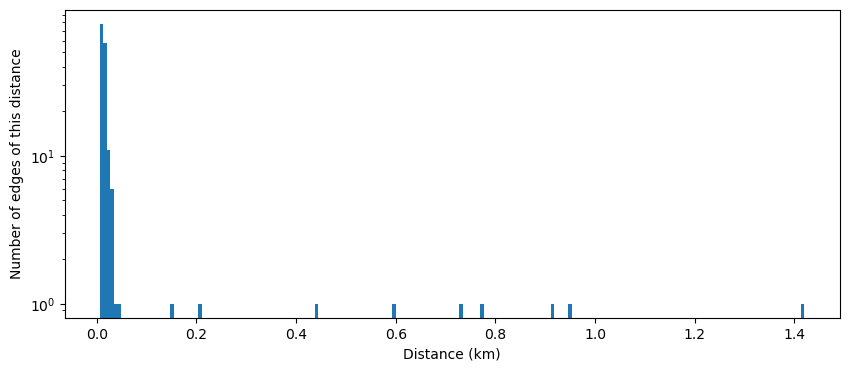

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  334
Number of edges in the minimum spanning tree:  333
Total distance of minimum spanning tree (in km):  9.209433999167507
Plotting results:


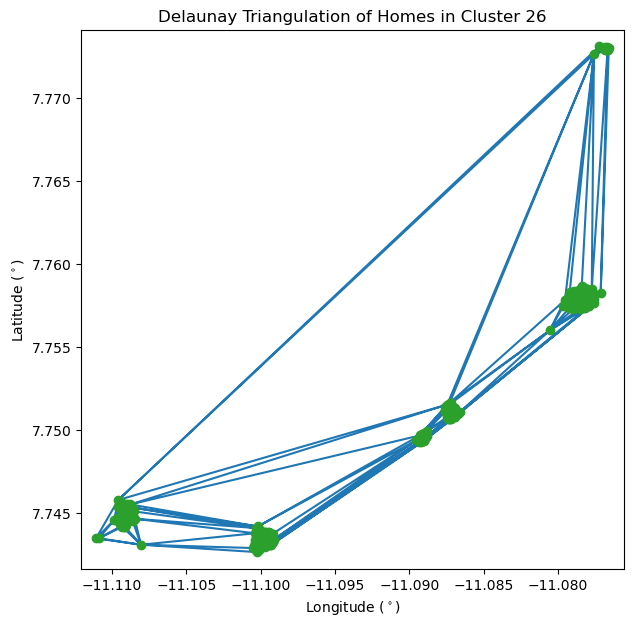

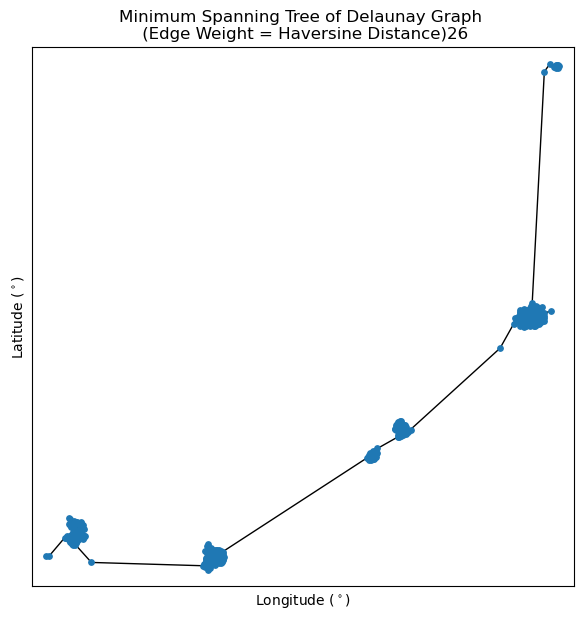

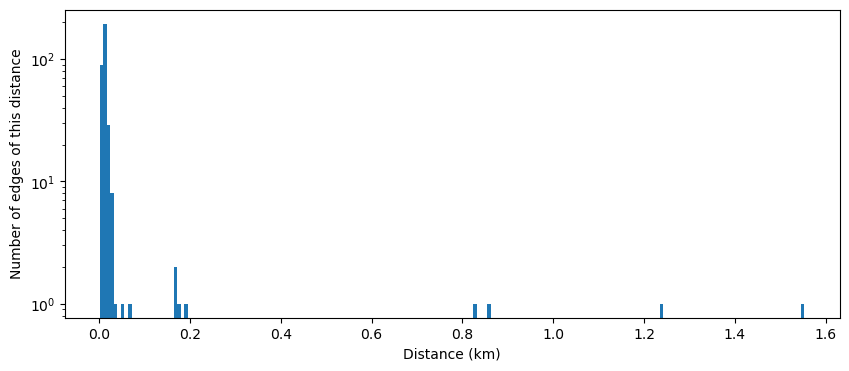

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  177
Number of edges in the minimum spanning tree:  176
Total distance of minimum spanning tree (in km):  6.613288944517103
Plotting results:


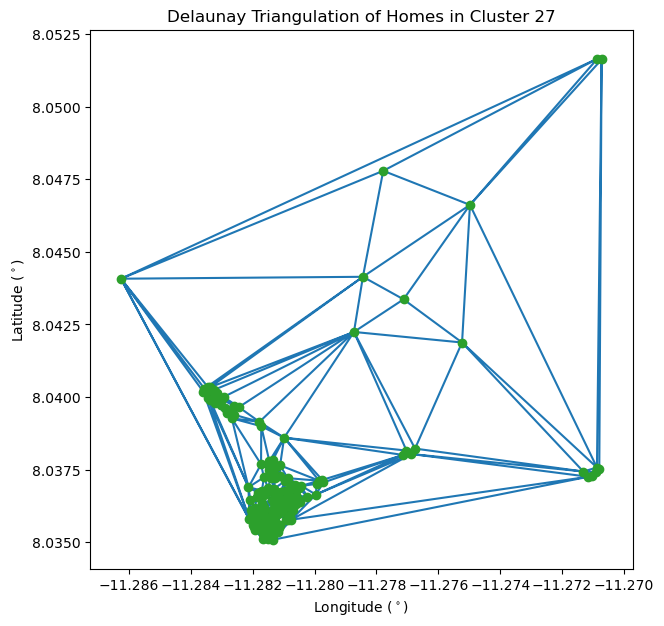

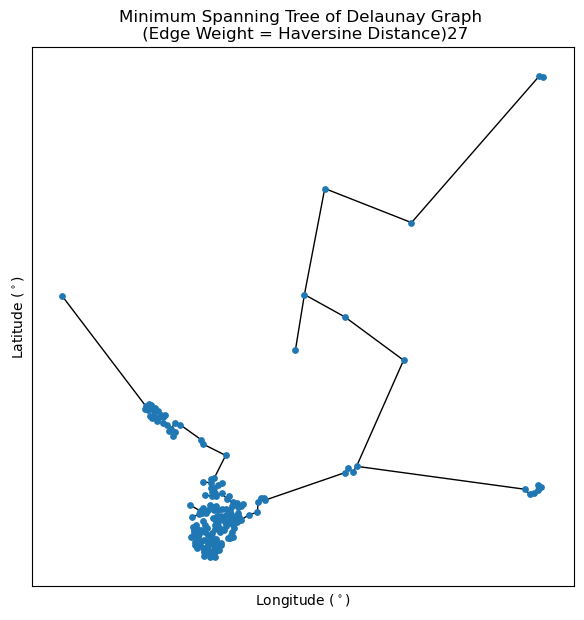

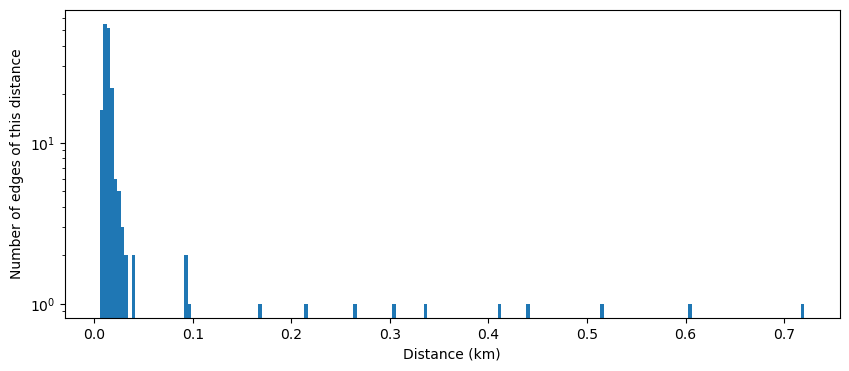

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  241
Number of edges in the minimum spanning tree:  240
Total distance of minimum spanning tree (in km):  9.847802169740776
Plotting results:


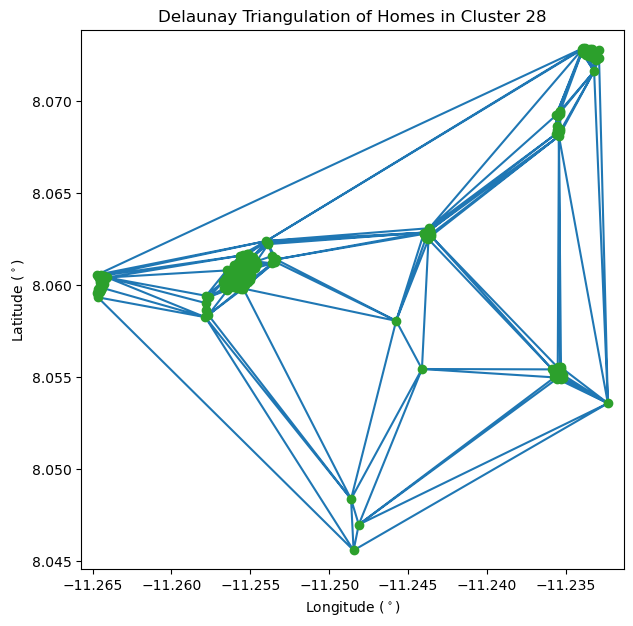

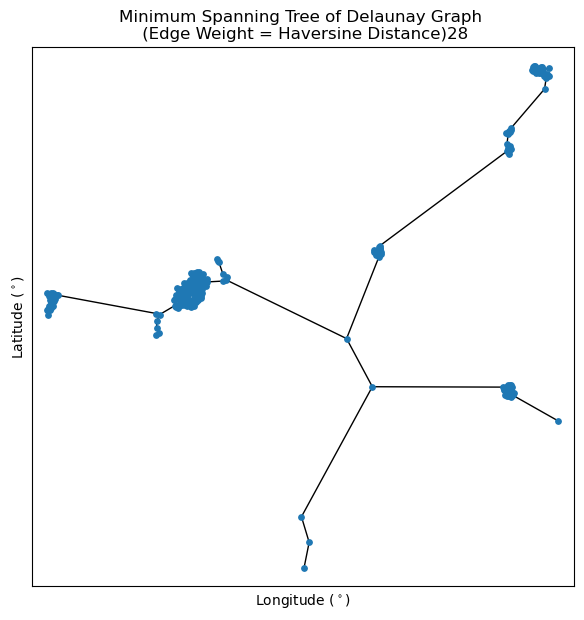

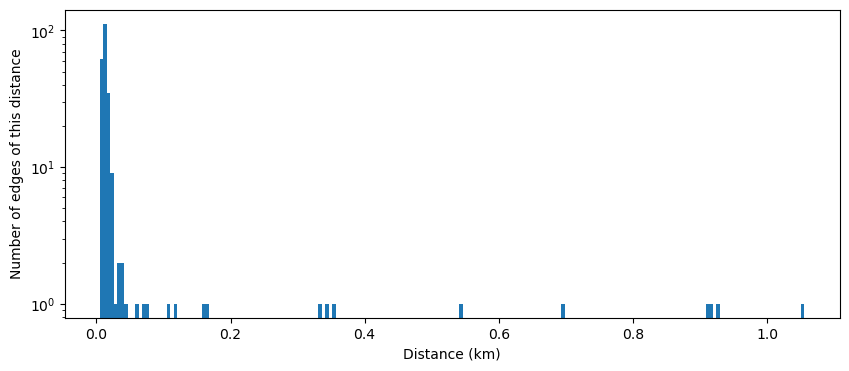

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  58
Number of edges in the minimum spanning tree:  57
Total distance of minimum spanning tree (in km):  2.1126781102468444
Plotting results:


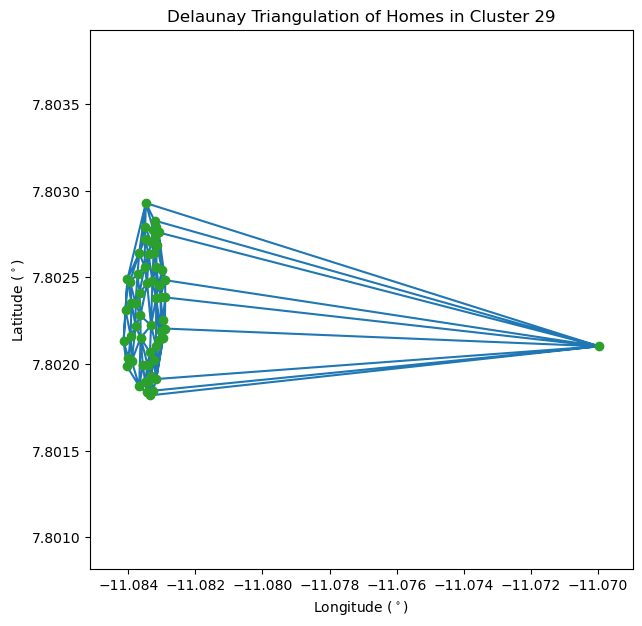

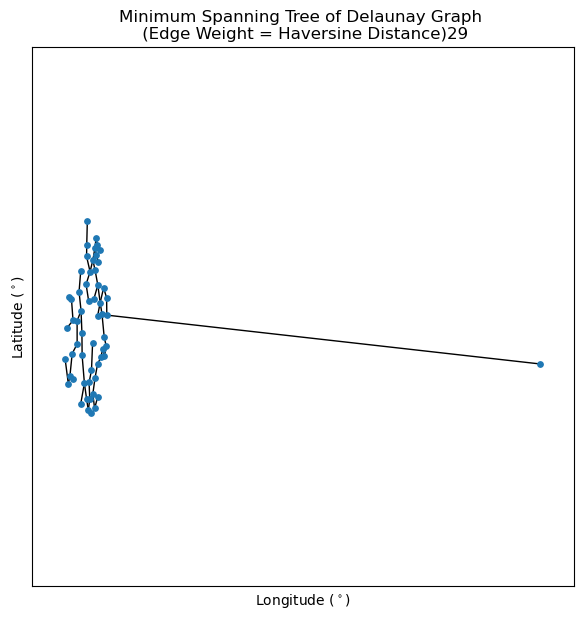

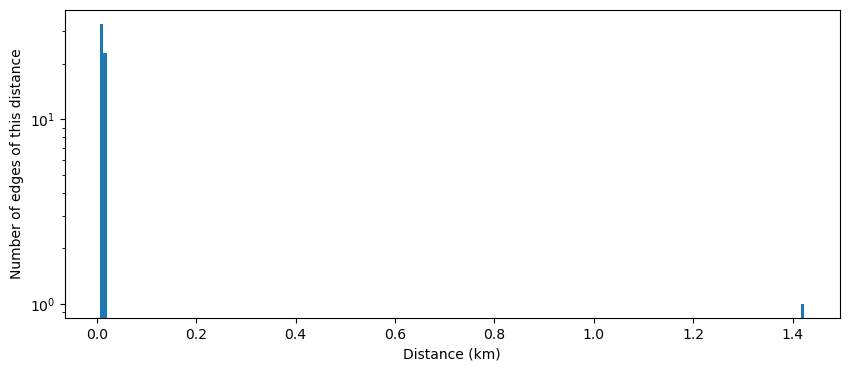

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  335
Number of edges in the minimum spanning tree:  334
Total distance of minimum spanning tree (in km):  9.342970374456751
Plotting results:


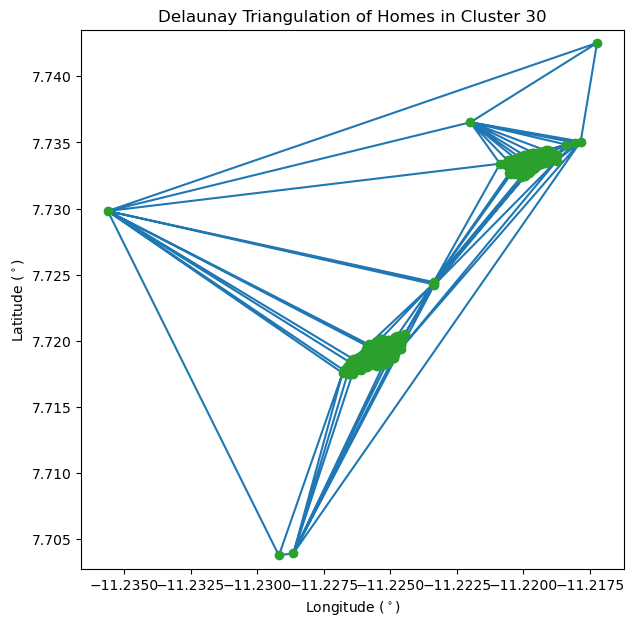

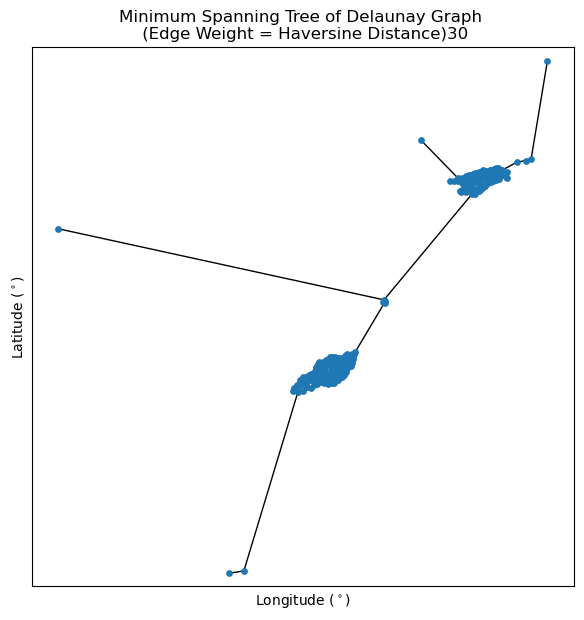

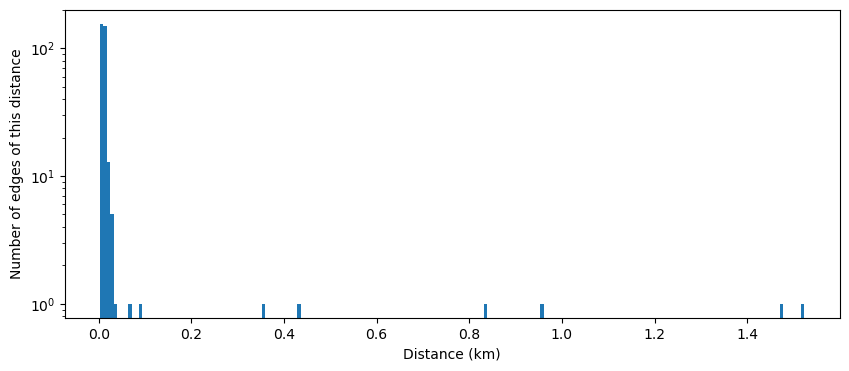

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  577
Number of edges in the minimum spanning tree:  576
Total distance of minimum spanning tree (in km):  23.522143919237276
Plotting results:


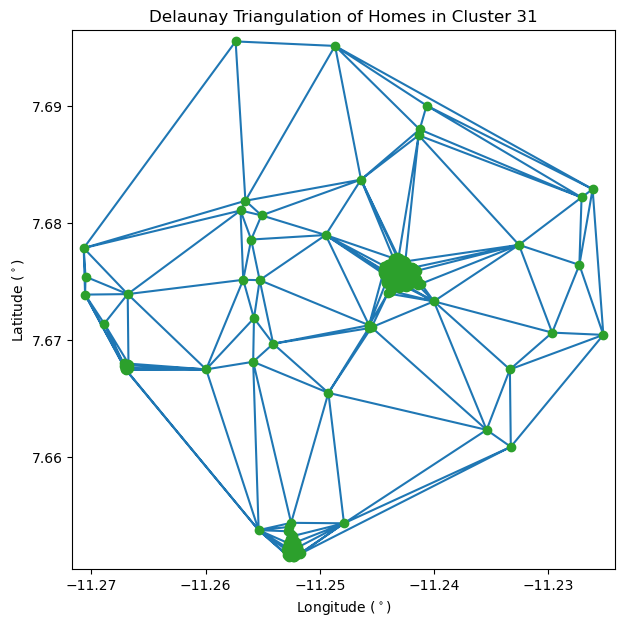

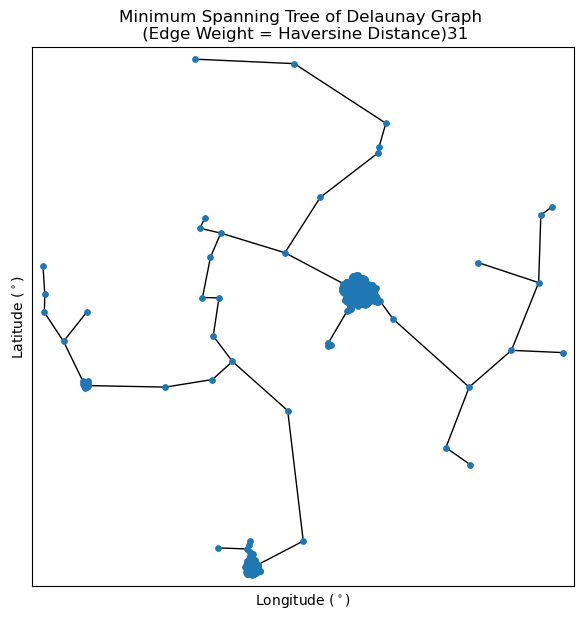

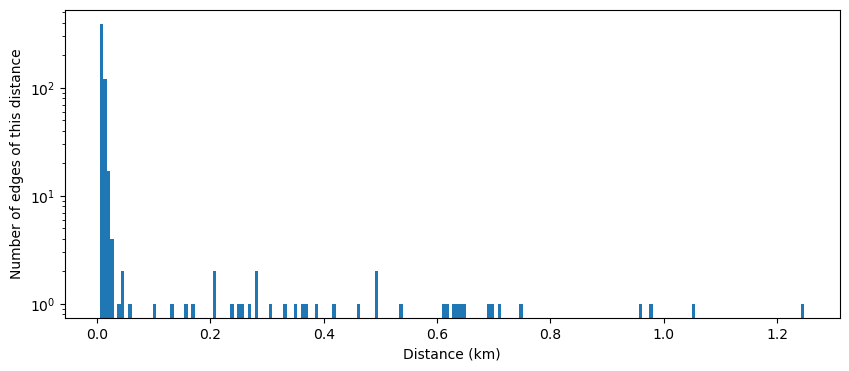

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  64
Number of edges in the minimum spanning tree:  63
Total distance of minimum spanning tree (in km):  3.6864624443541745
Plotting results:


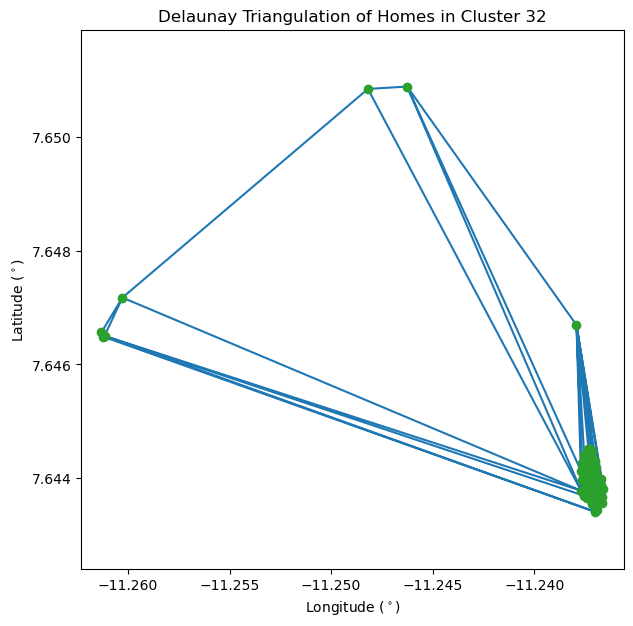

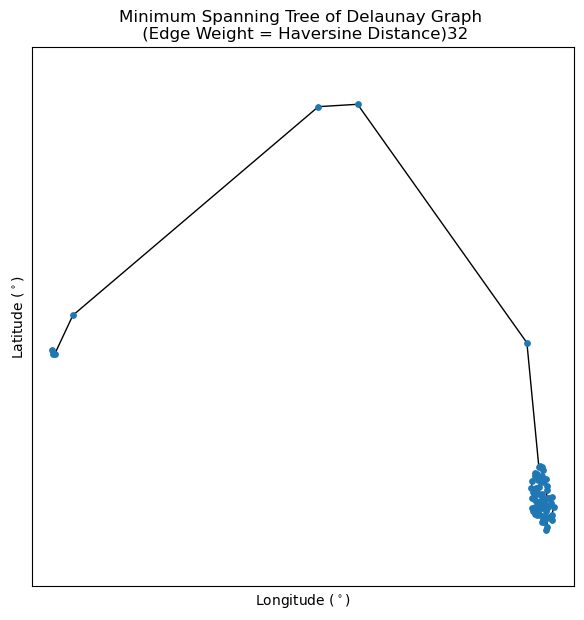

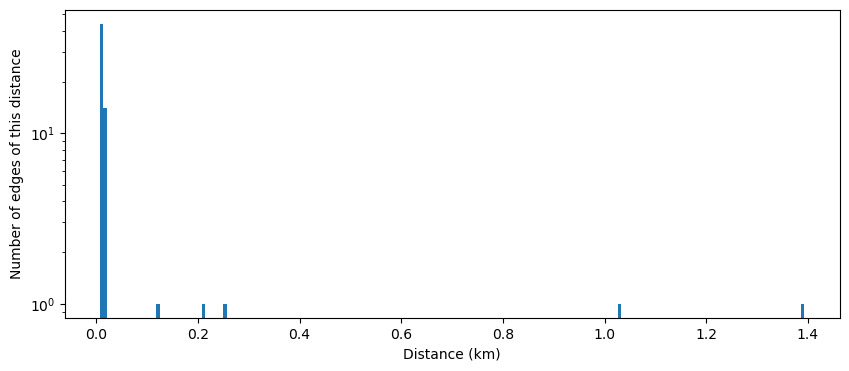

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  514
Number of edges in the minimum spanning tree:  513
Total distance of minimum spanning tree (in km):  36.481325546220525
Plotting results:


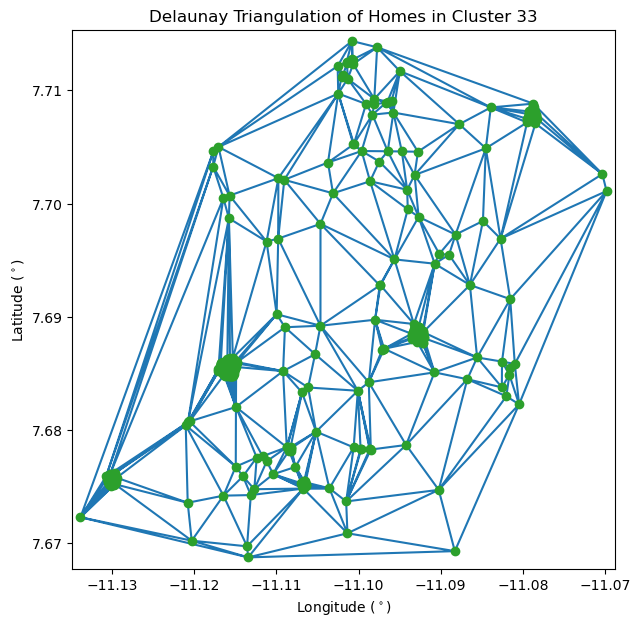

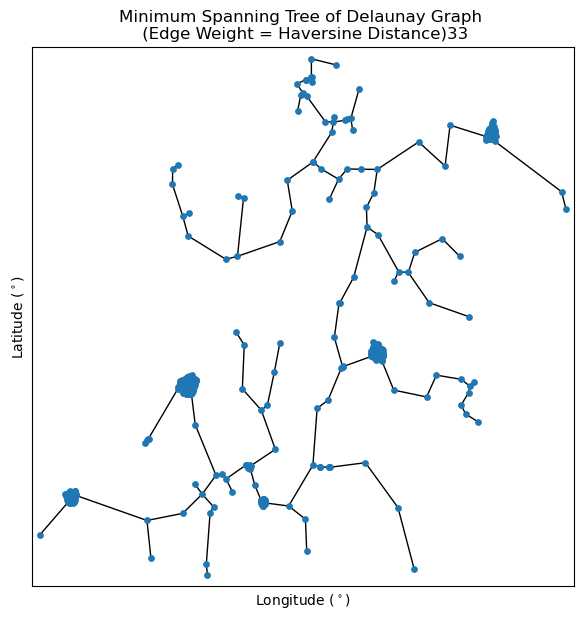

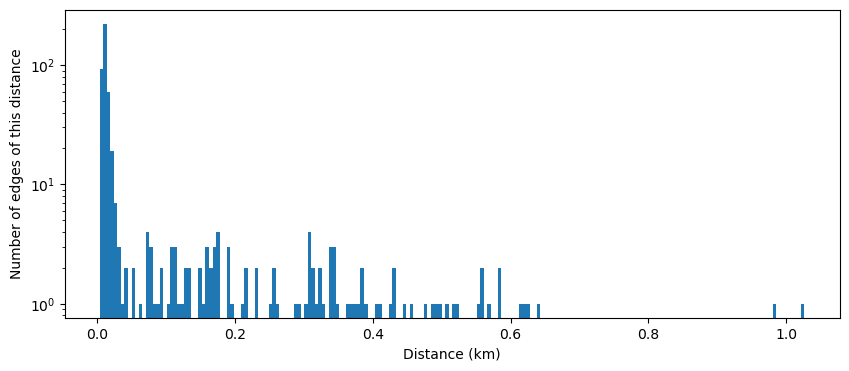

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  391
Number of edges in the minimum spanning tree:  390
Total distance of minimum spanning tree (in km):  11.528469687942268
Plotting results:


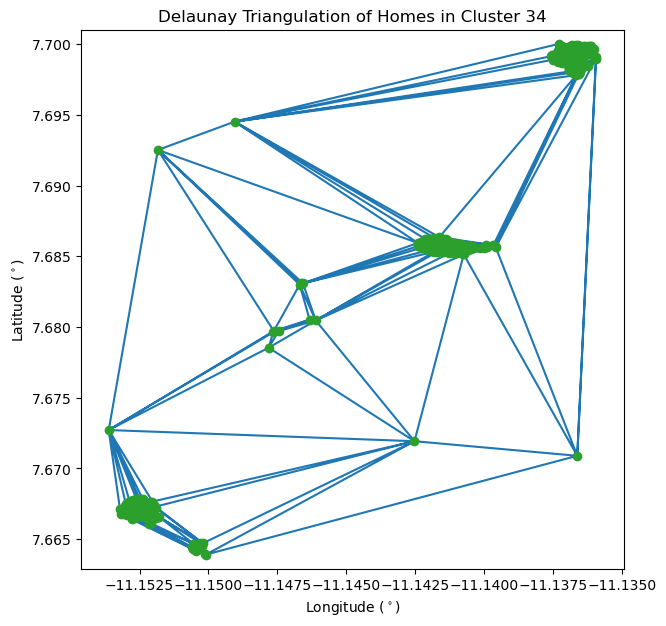

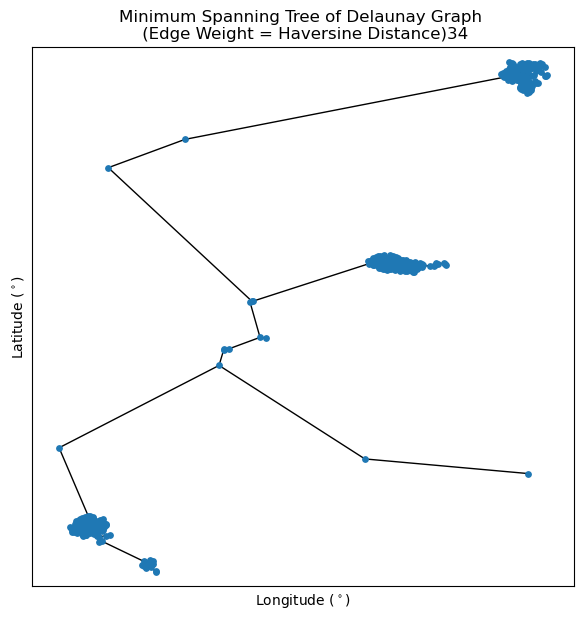

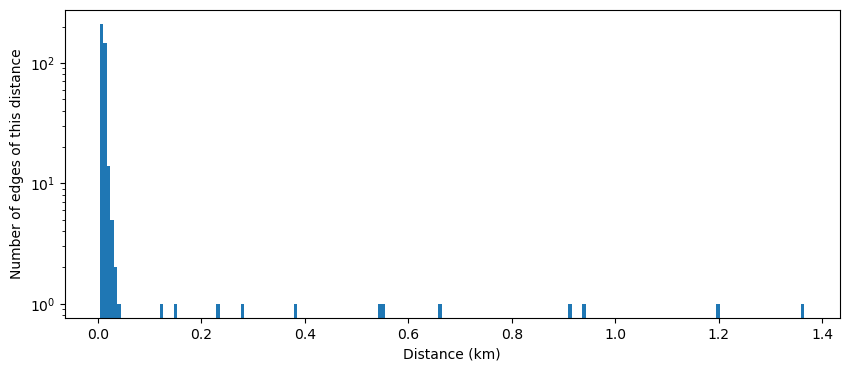

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  399
Number of edges in the minimum spanning tree:  398
Total distance of minimum spanning tree (in km):  18.830766084496474
Plotting results:


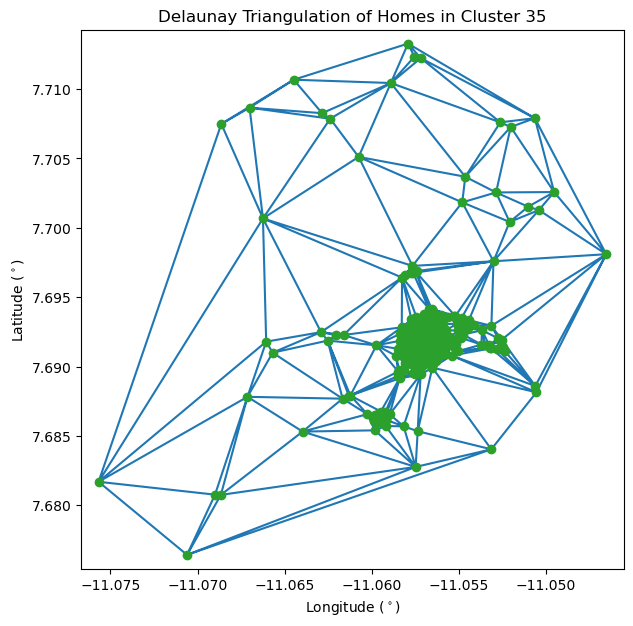

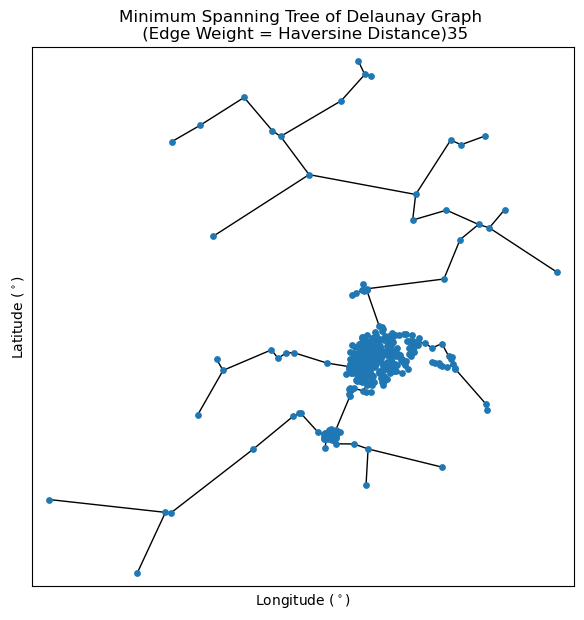

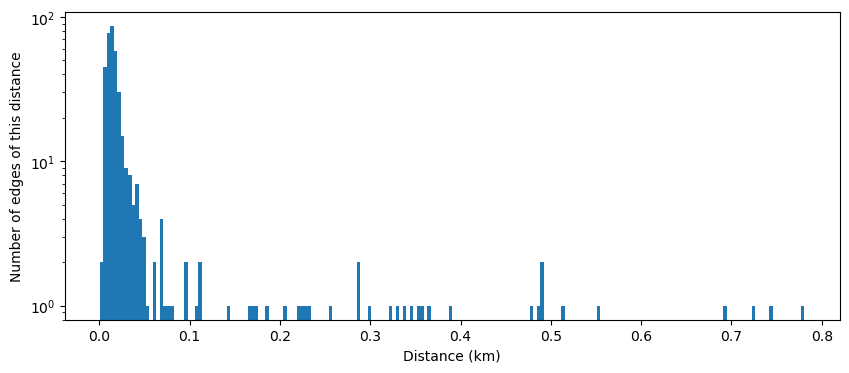

Calculating Delaunay triangulation and distance between Delaunay neighbours...
Creating a graph from this information (edge weight = distance)...
Calculating the minimum spanning tree of the graph...
Number of nodes (buildings) in the graph:  1113
Number of edges in the minimum spanning tree:  1112
Total distance of minimum spanning tree (in km):  41.561076908649774
Plotting results:


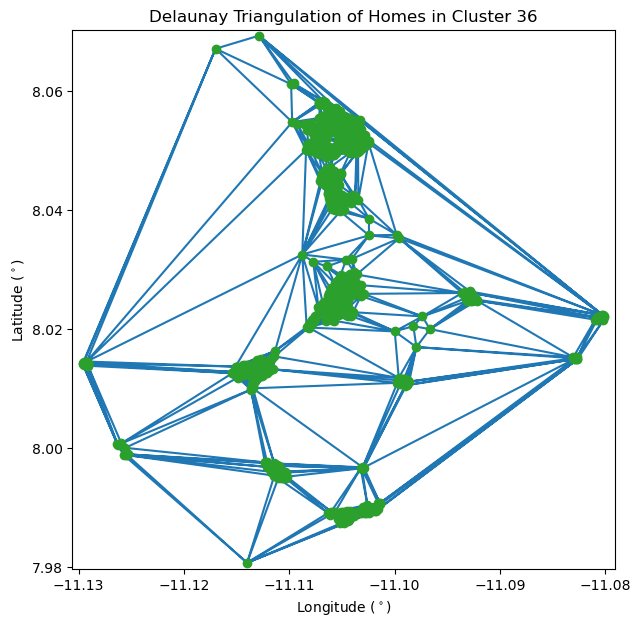

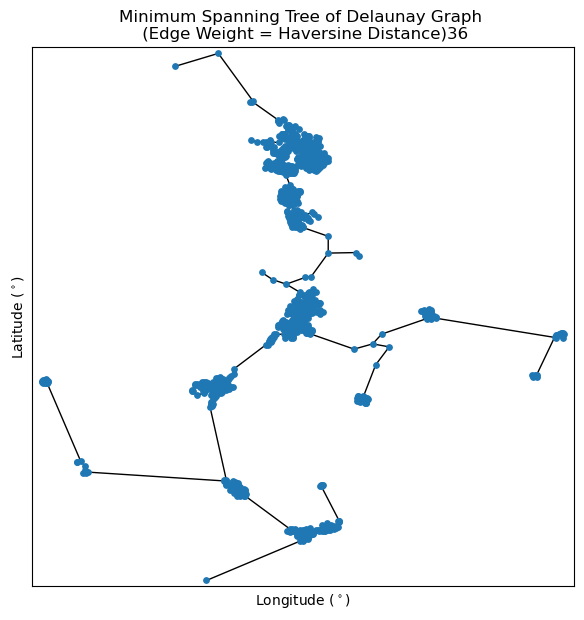

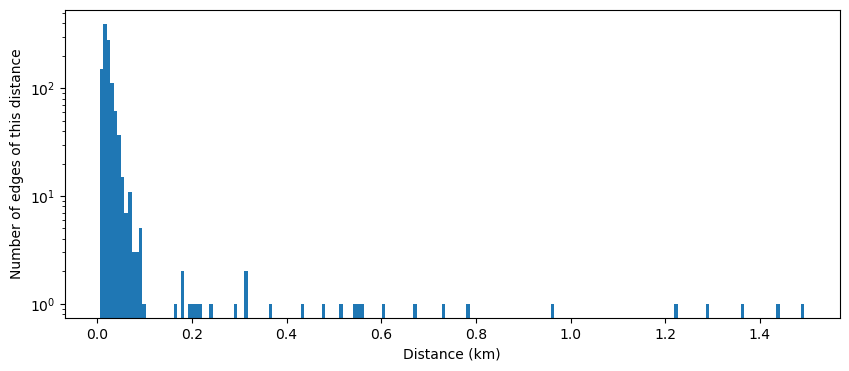

In [30]:
for clust_label in range (0, len(frequencies)-1 ):
    # Get Delauney triangulation of coordinates
    clust_coords = coords[labels == clust_label]
    no_points = clust_coords.shape[0]
    print('Calculating Delaunay triangulation and distance between Delaunay neighbours...')
        
    tri = Delaunay(clust_coords)
    indices = tri.vertex_neighbor_vertices[0]
    indptr = tri.vertex_neighbor_vertices[1]

    # Instantiate dictionary to hold neighbors of each point & data-frame to hold distances between neighbours
    neighbors = {}
    locations = {}
    distances = pd.DataFrame(columns=["source", "dest", "distance"])

    # Get dictionary of neighbors of all points and a dictionary of locations of all points
    for k in range(0, no_points):
        neighbors[k] = indptr[indices[k]:indices[k+1]]
        locations[k] = clust_coords[k][0], clust_coords[k][1]

    # Get distances between all Delaunay neighbors
    for key, values in neighbors.items():
        for value in values:
            coord_1 = clust_coords[key]
            coord_2 = clust_coords[value]
            dist = haversine_dist_from_coords(coord_1[1], coord_1[0], coord_2[1], coord_2[0])
            distances = distances.append({"source": key, "dest": value, "distance": dist}, ignore_index=True)

    # Plot Delaunay triangulation
    plt.figure(figsize=(7, 7))
    title_1 = 'Delaunay Triangulation of Homes in Cluster ' + str(clust_label)
    plt.title(title_1)
    plt.triplot(clust_coords[:, 0], clust_coords[:, 1], tri.simplices)
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    plt.plot(clust_coords[:, 0], clust_coords[:, 1], 'o')
    axes = plt.gca()
    axes.set_xlim([min(clust_coords[:, 0]) - 0.001, max(clust_coords[:, 0]) + 0.001])
    axes.set_ylim([min(clust_coords[:, 1]) - 0.001, max(clust_coords[:, 1]) + 0.001])
    
    print('Creating a graph from this information (edge weight = distance)...')
    G = nx.Graph()
    for index, row in distances.iterrows():
        G.add_edge(row['source'], row['dest'], weight=row['distance'])

    print('Calculating the minimum spanning tree of the graph...')
    T = nx.minimum_spanning_tree(G)

    edges = T.edges(data=True)
    weights = [x[2]['weight'] for x in edges]
    total_dist = sum(weights)

    # Create a geopandas dataframe and save as .shp
    # create an array of LineString from T
    lines = [LineString([(clust_coords[int(edge[0]),0],clust_coords[int(edge[0]),1]),(clust_coords[int(edge[1]),0],clust_coords[int(edge[1]),1])]) for edge in edges]
    d = {'geometry':lines}
    mstDF = gp.GeoDataFrame(d, crs="EPSG:4326")
    mstDF.to_file(f'./ShapeFiles_Kenema/MinimiumSpanningTree_{clust_label}.shp')
    
    print('Number of nodes (buildings) in the graph: ', T.number_of_nodes())
    print('Number of edges in the minimum spanning tree: ', T.number_of_edges())
    print('Total distance of minimum spanning tree (in km): ', total_dist)

    print('Plotting results:')

    # Plot Minimum Spanning Tree made from Delaunay Triangulation
    plt.figure(figsize=(7, 7))
    nx.draw_networkx(T, pos=locations, with_labels=False, node_size=15)
    title_2 = 'Minimum Spanning Tree of Delaunay Graph \n (Edge Weight = Haversine Distance)' + str(clust_label)
    plt.title(title_2)
    plt.xlabel('Longitude ($^\circ$)')
    plt.ylabel('Latitude ($^\circ$)')
    axes = plt.gca()
    axes.set_xlim([min(clust_coords[:, 0]) - 0.001, max(clust_coords[:, 0]) + 0.001])
    axes.set_ylim([min(clust_coords[:, 1]) - 0.001, max(clust_coords[:, 1]) + 0.001])
    
    # Plot relative frequency of edge distances in minimum spanning tree
    plt.figure(figsize=(10, 4))
    plt.hist(weights, bins=200)
    plt.yscale("log")
    plt.ylabel('Number of edges of this distance')
    plt.xlabel('Distance (km)')

    plt.show()